In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
OKABE_ITO_SCALE = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
""
%load_ext autoreload
%autoreload 2

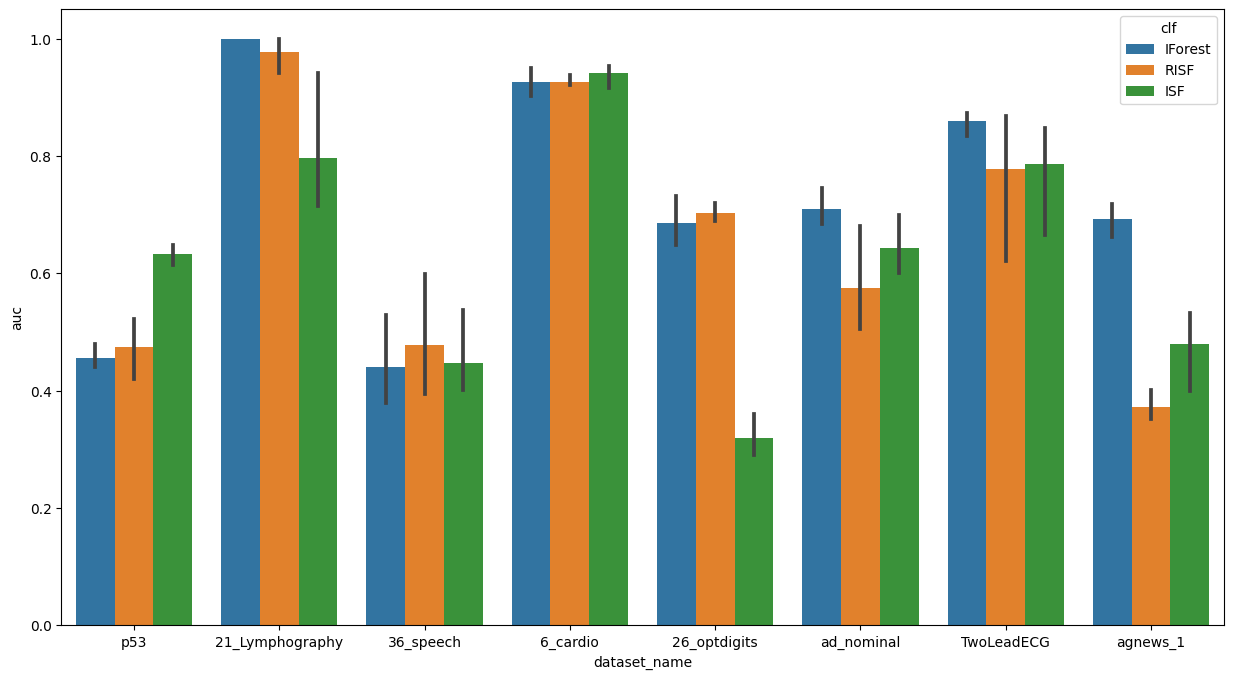

In [3]:
df = pd.read_csv('../results/results_default.csv')
sns.barplot(data=df, x="dataset_name", y="auc", hue="clf")
plt.gcf().set_size_inches(15, 8) # We don't need to check Isolation forest, maybe just for debugging.

In [2]:
def sensitivity_plot(csv_path, parameter_name, col_wrap=4):
    results = pd.read_csv(csv_path)
    sns.set_palette(sns.color_palette(OKABE_ITO_SCALE))
    g = sns.relplot(data=results, x=parameter_name, y="auc", hue="clf", marker="o", col="dataset_name", col_wrap=col_wrap, 
                facet_kws={'sharey': False, 'sharex': False}, kind="line")
    g.set(ylim=(0, 1))
    g.fig.suptitle(f'influence of {parameter_name} on AUC')
    plt.gcf().set_size_inches(20, 10)

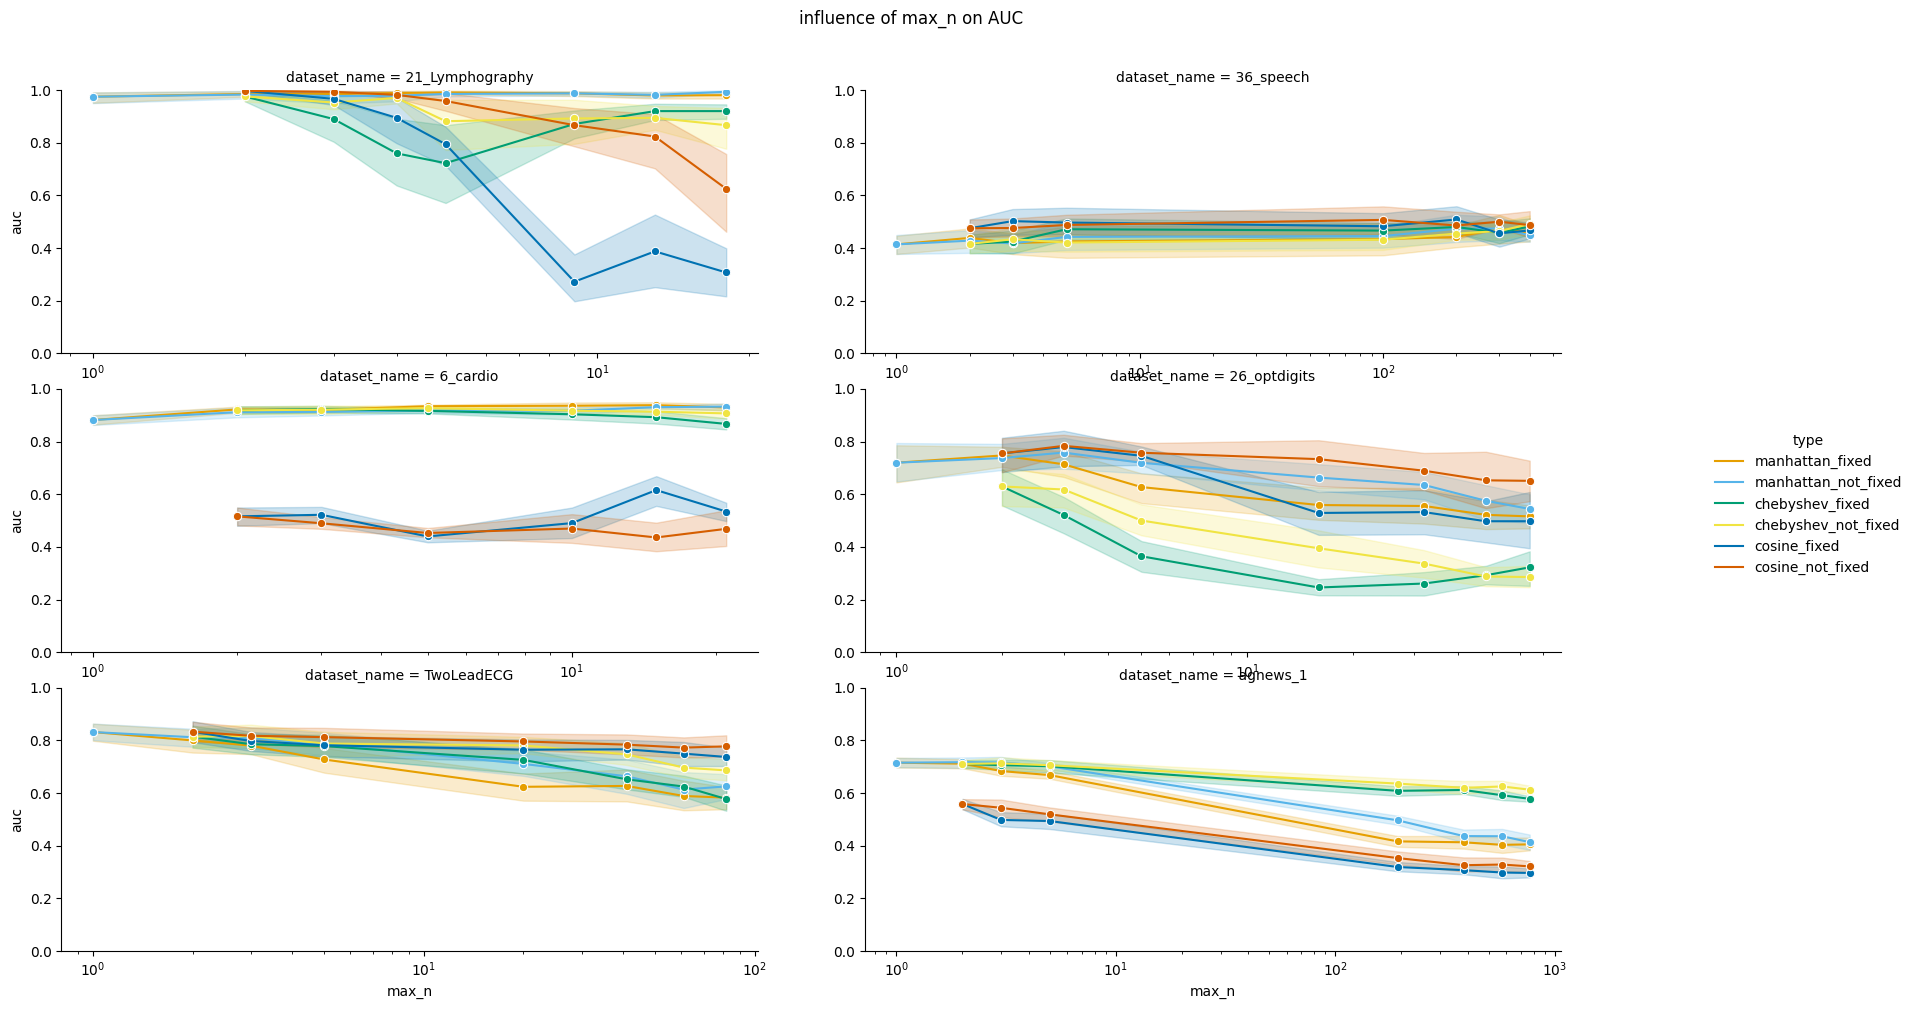

In [29]:
dfs = []
for dist in ["manhattan", "chebyshev", "cosine"]:
    df1 = pd.read_csv(f"../results/{dist}_projection-fixed-max_n.csv")
    df2 = pd.read_csv(f"../results/{dist}_projection-not_fixed-max_n.csv")
    df1.drop(columns=[f"{dist}_projection-fixed-max_n"], inplace=True)
    df2.drop(columns=[f"{dist}_projection-not_fixed-max_n"], inplace=True)

    df1["type"] = dist + "_fixed"
    df2["type"] = dist + "_not_fixed"

    dfs.append(pd.concat([df1, df2], ignore_index=True))

df = pd.concat(dfs, ignore_index=True)

sns.set_palette(sns.color_palette(OKABE_ITO_SCALE))
g = sns.relplot(data=df, x="max_n", y="auc", hue="type", marker="o", col="dataset_name", col_wrap=2, 
            facet_kws={'sharey': False, 'sharex': False}, kind="line")
g.set(ylim=(0, 1))
g.fig.suptitle(f'influence of max_n on AUC')
g.set(xscale="log")
g.fig.subplots_adjust(top=0.9)
plt.gcf().set_size_inches(20, 10)

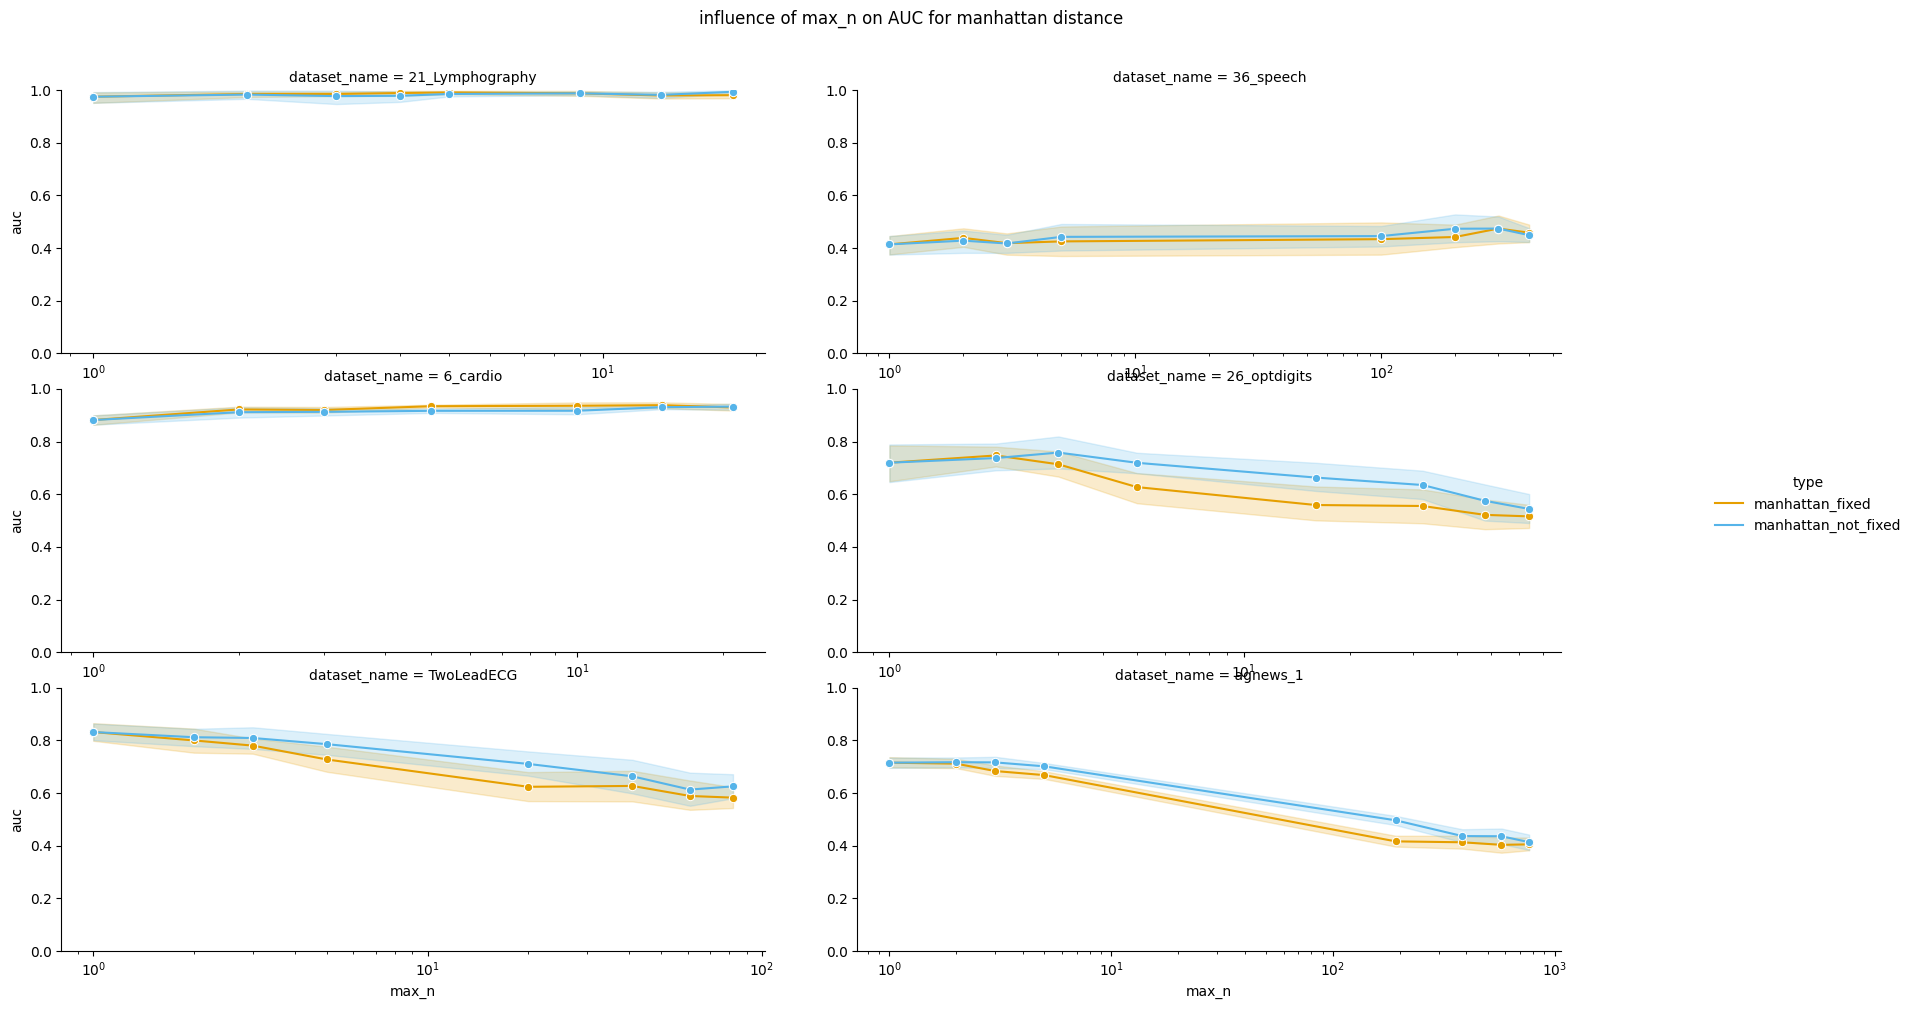

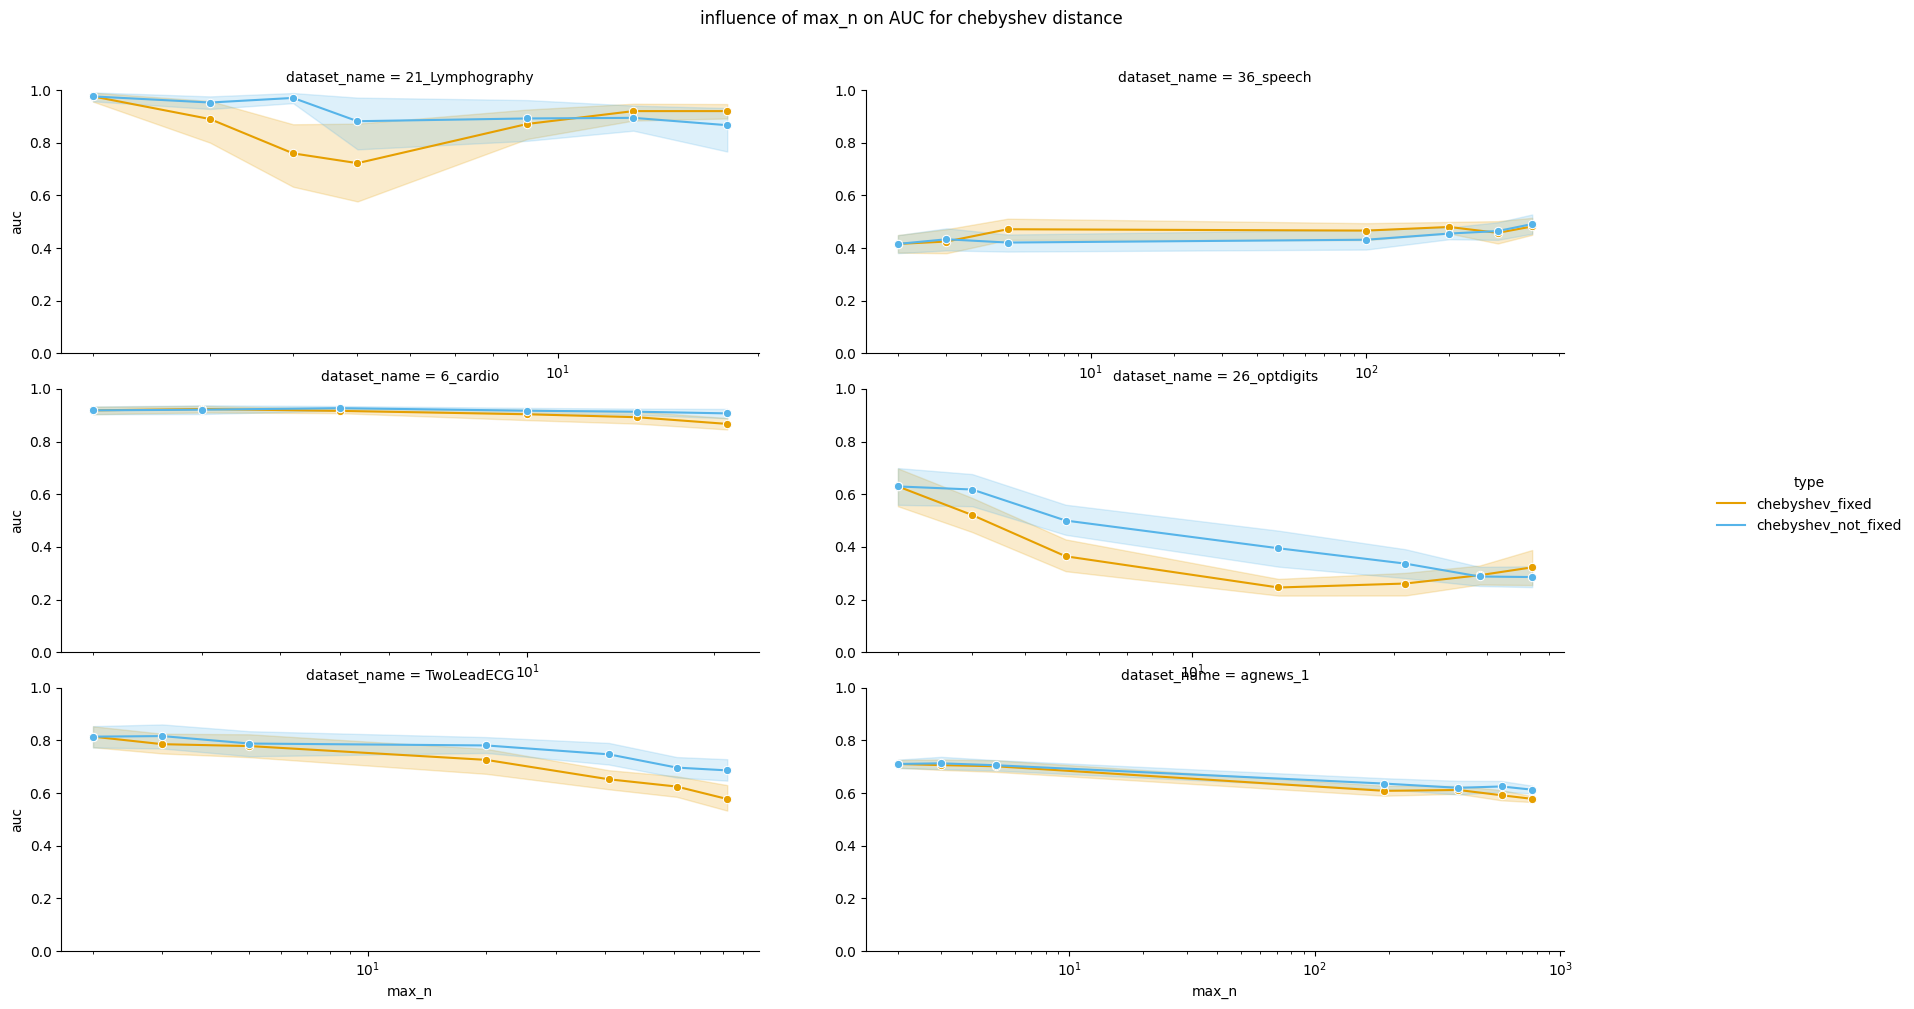

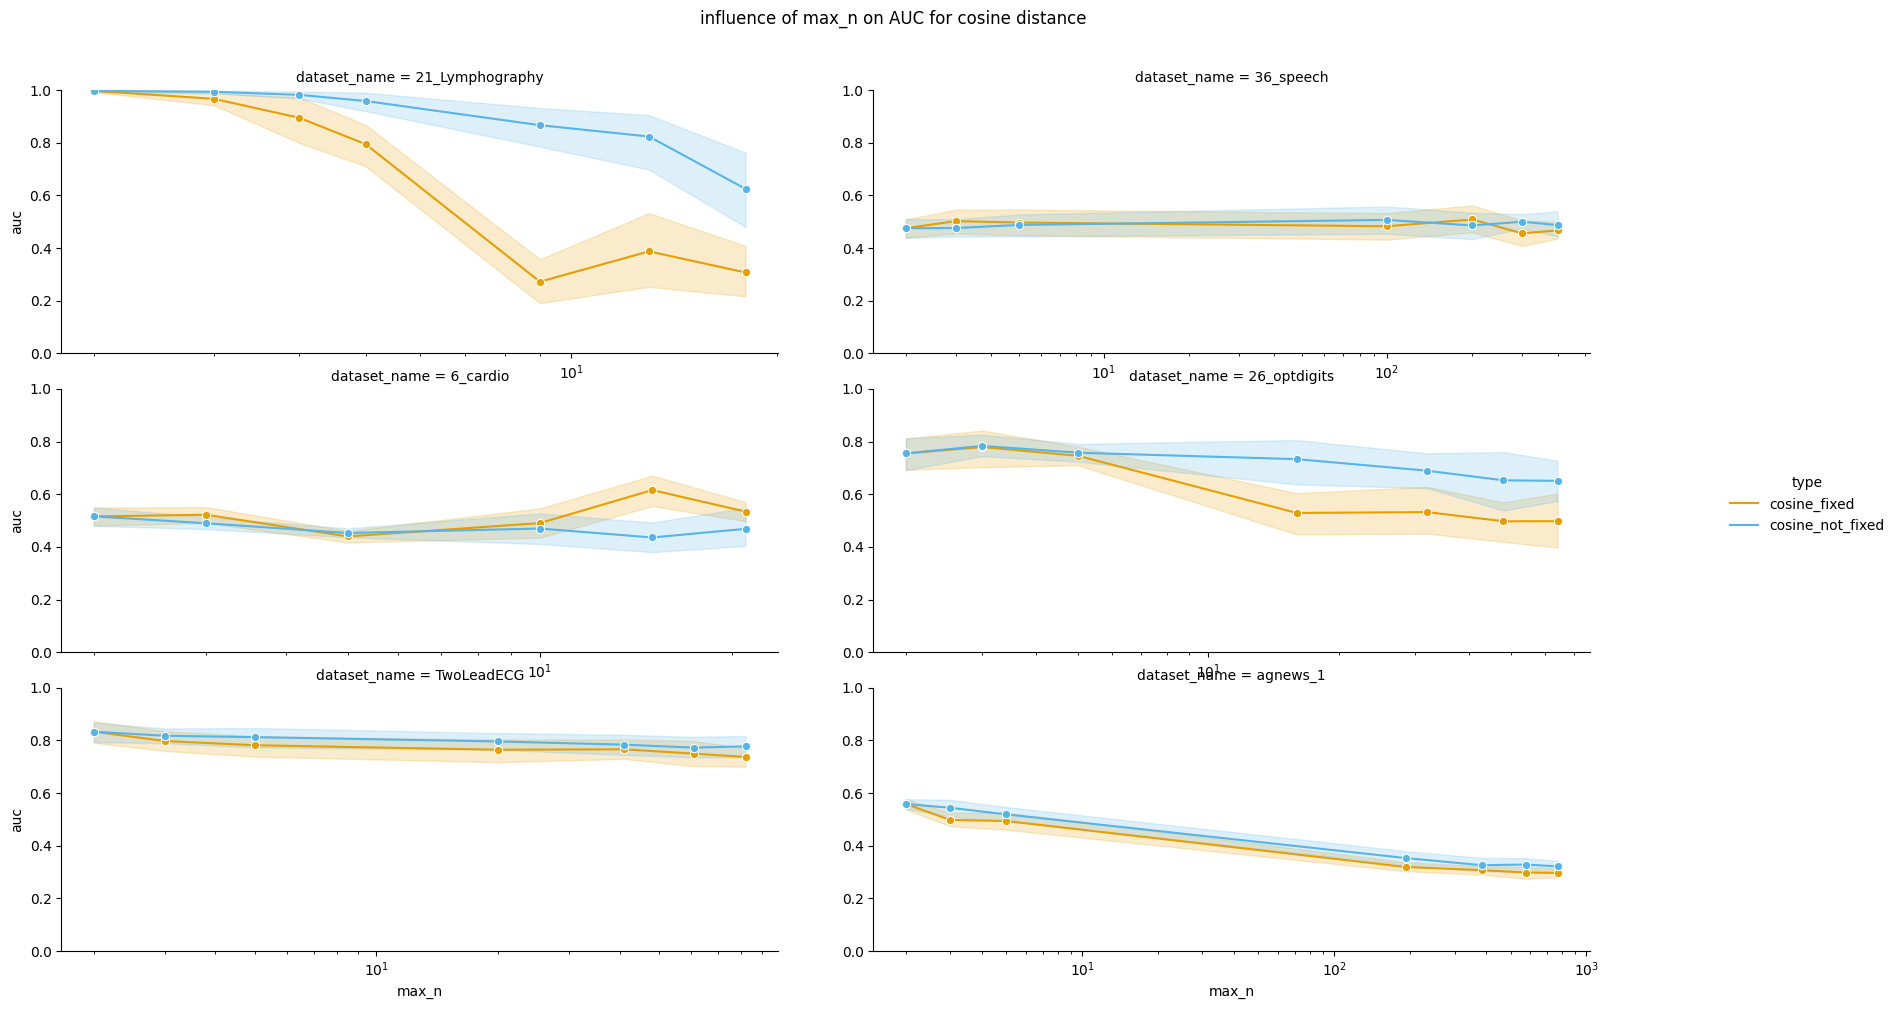

In [31]:
for dist in ["manhattan", "chebyshev", "cosine"]:
    df1 = pd.read_csv(f"../results/{dist}_projection-fixed-max_n.csv")
    df2 = pd.read_csv(f"../results/{dist}_projection-not_fixed-max_n.csv")
    df1.drop(columns=[f"{dist}_projection-fixed-max_n"], inplace=True)
    df2.drop(columns=[f"{dist}_projection-not_fixed-max_n"], inplace=True)

    df1["type"] = dist + "_fixed"
    df2["type"] = dist + "_not_fixed"

    df = pd.concat([df1, df2], ignore_index=True)

    sns.set_palette(sns.color_palette(OKABE_ITO_SCALE))
    g = sns.relplot(data=df, x="max_n", y="auc", hue="type", marker="o", col="dataset_name", col_wrap=2, 
            facet_kws={'sharey': False, 'sharex': False}, kind="line")
    g.set(ylim=(0, 1))
    g.fig.suptitle(f'influence of max_n on AUC for {dist} distance')
    g.set(xscale="log")
    g.fig.subplots_adjust(top=0.9)
    plt.gcf().set_size_inches(20, 10)

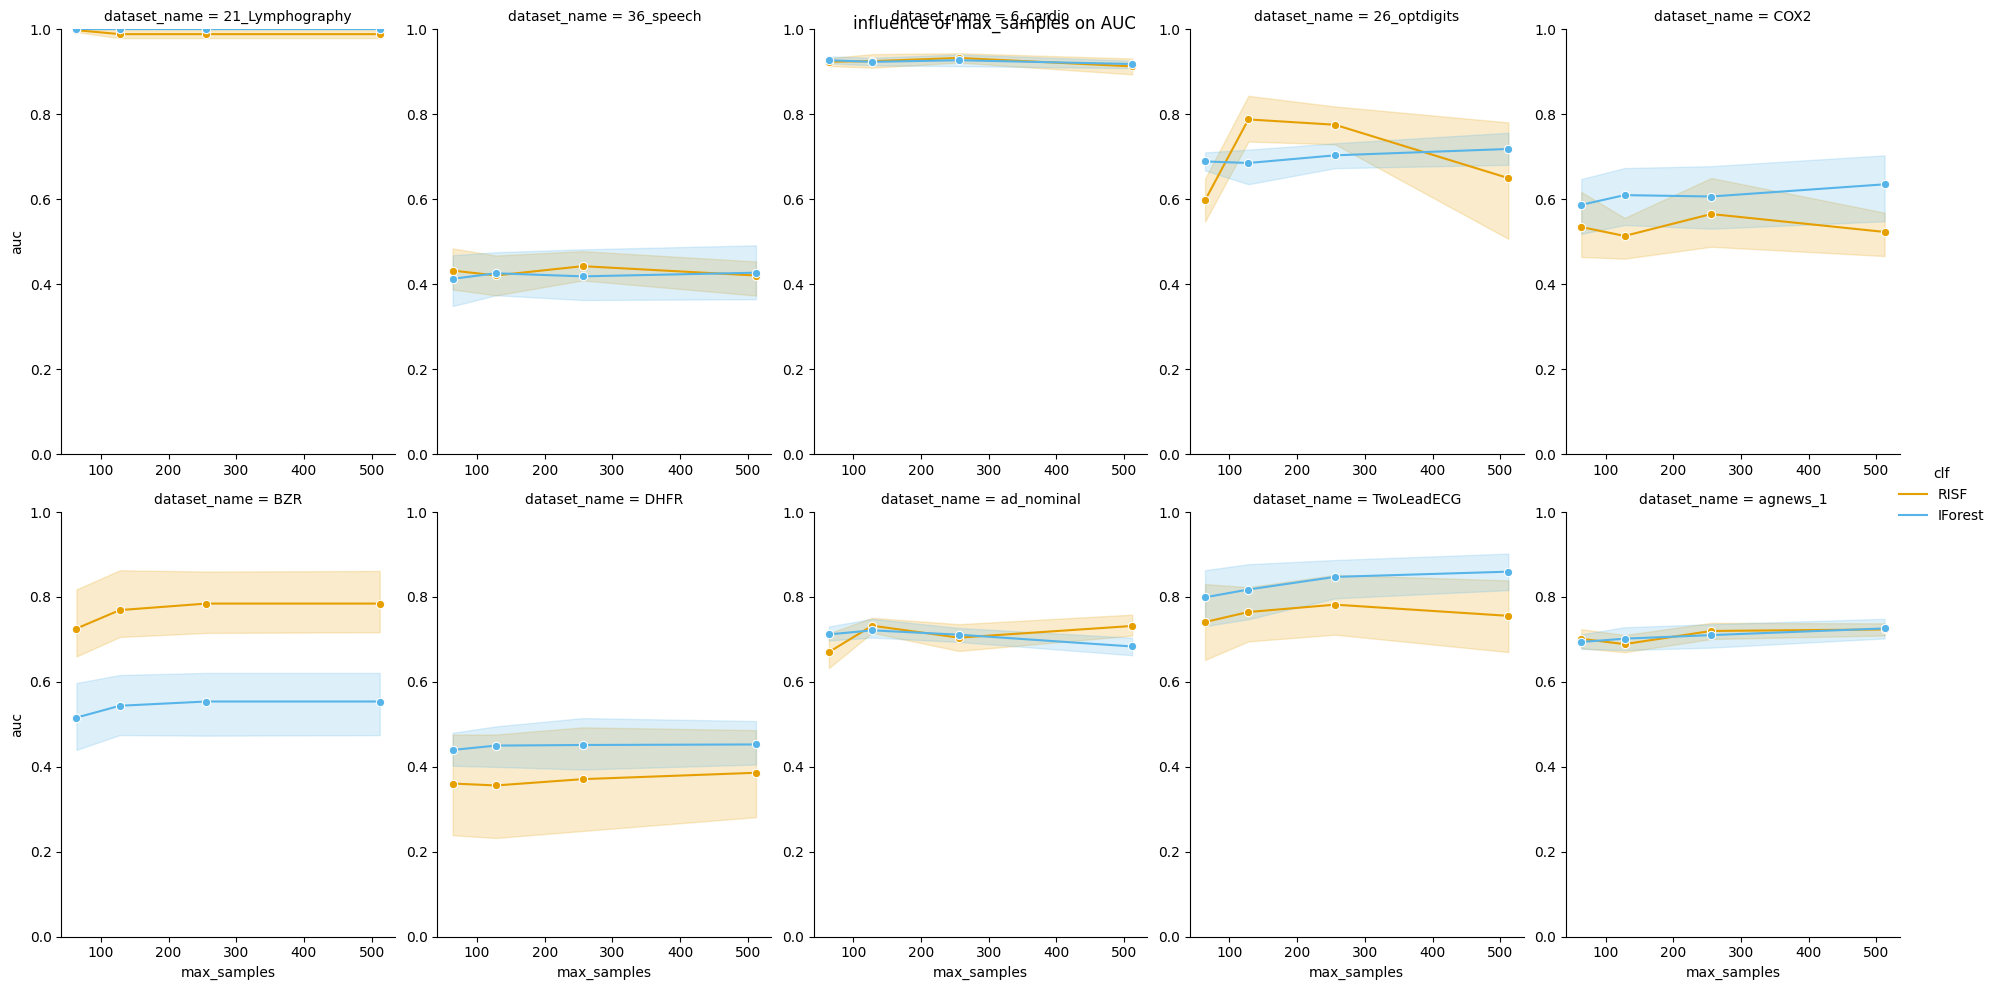

In [4]:
sensitivity_plot("../results/results_max_samples.csv", "max_samples",5)

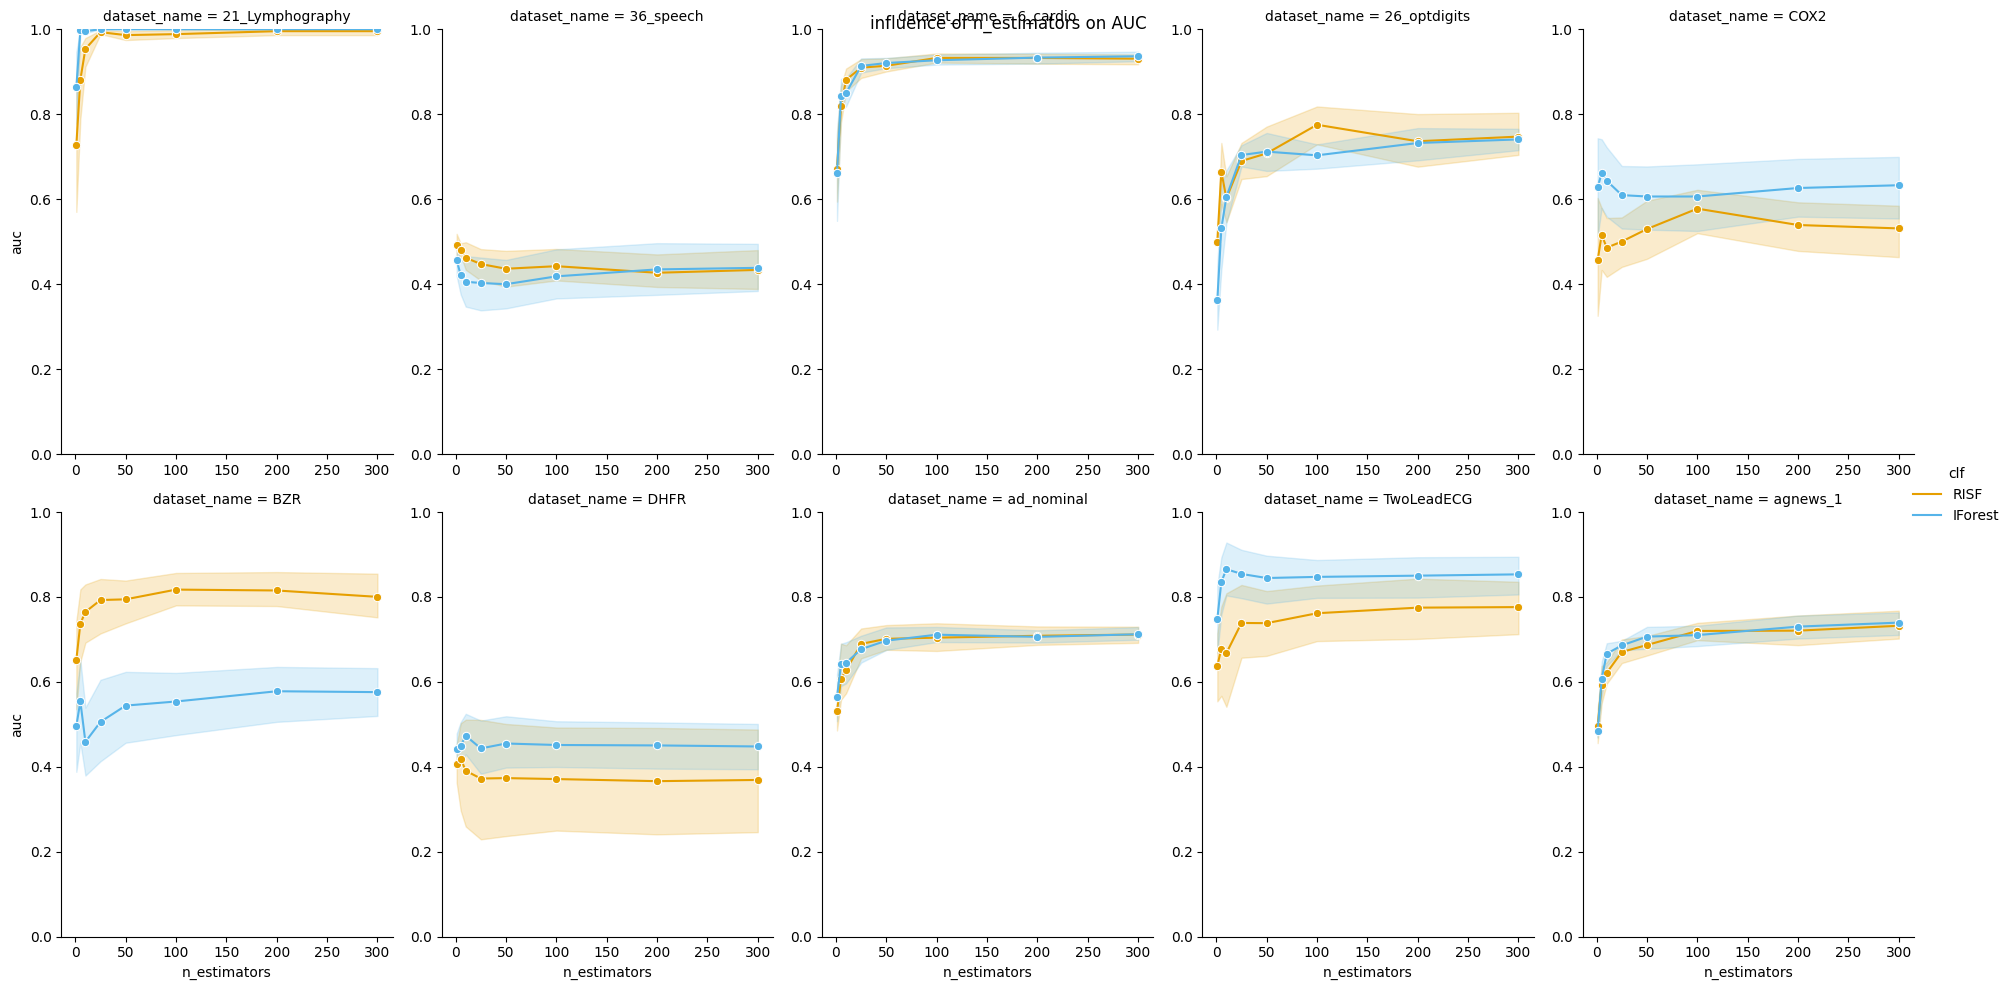

In [5]:
sensitivity_plot("../results/results_n_estimators.csv", "n_estimators", 5)

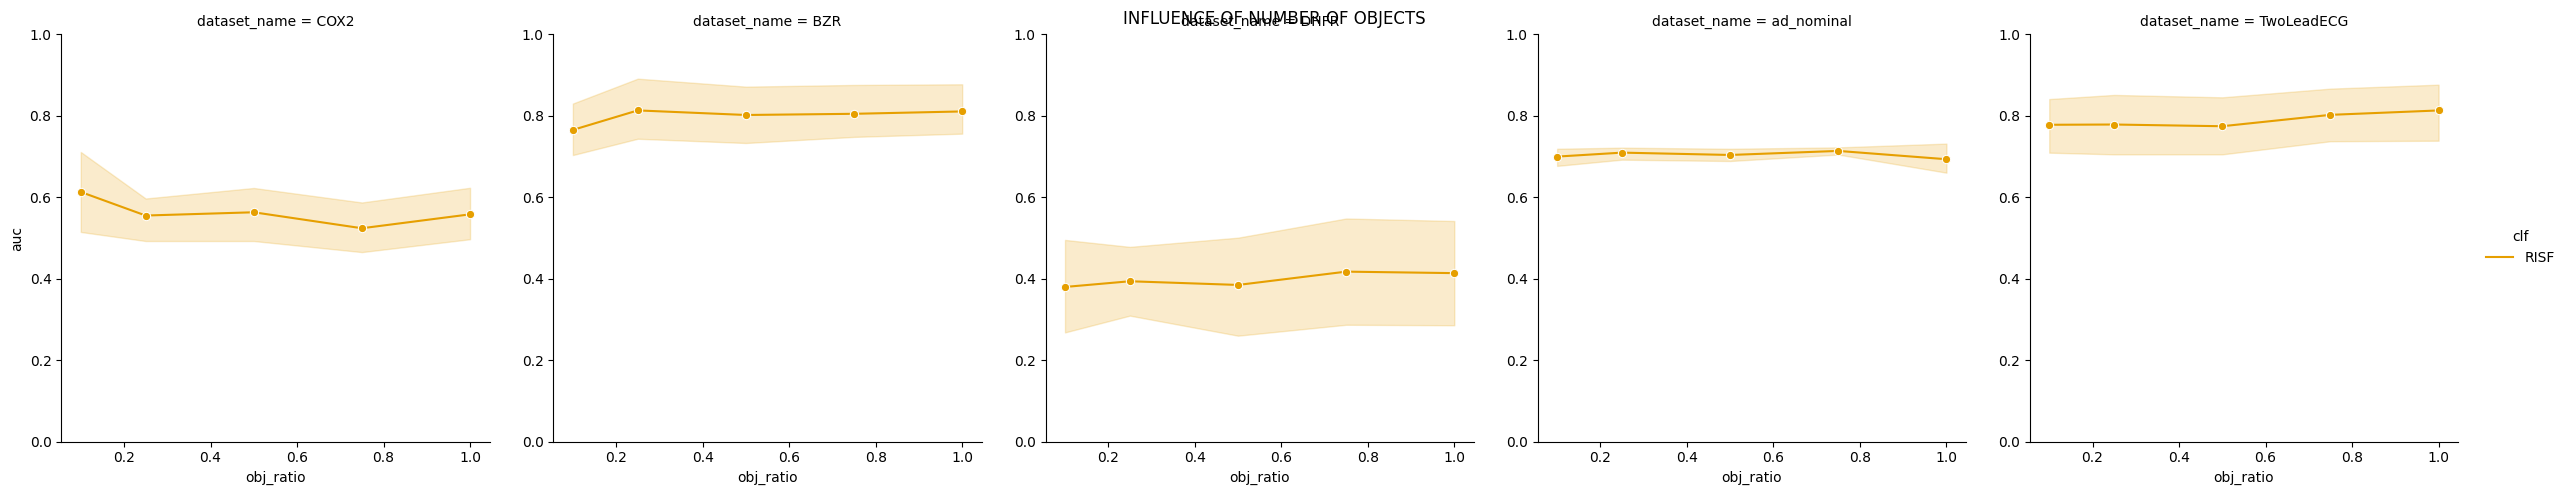

In [7]:
results_df = pd.read_csv("../results/results_selected_obj_Ratio.csv")
sns.set_palette(sns.color_palette(OKABE_ITO_SCALE))
g = sns.relplot(data=results_df, x="obj_ratio", y="auc", hue="clf", marker="o", col="dataset_name", col_wrap=5, 
            facet_kws={'sharey': False, 'sharex': False}, kind="line")

g.fig.suptitle('INFLUENCE OF NUMBER OF OBJECTS')
g.set(ylim=(0, 1))
sns.despine()

In [8]:
def plot_top_n_dists(results, n=7):
    if_default = pd.read_csv("../results/results_if_default.csv")
    grouped = results.groupby(['dataset_name', 'distances']) 
    grouped_mean = grouped.mean().reset_index()
    datasets = grouped_mean.dataset_name.unique()
    fig, ax = plt.subplots(1, len(datasets),  figsize=(10 * len(datasets), 10))
    
    if not isinstance(ax, np.ndarray):
        ax = [ax]

    for i in range(0, len(datasets)):
        dataset_name = grouped_mean.dataset_name.unique()[i]
        if_score = if_default[if_default.dataset_name == dataset_name].auc.values
        if_mean = if_score.mean()
        if_std = if_score.std()
        top_n_dists = grouped_mean[grouped_mean.dataset_name == dataset_name].sort_values(by=['auc'], ascending=False).head(n).distances.values

        to_plot = results[results.dataset_name == dataset_name]
        to_plot = to_plot[to_plot.distances.isin(top_n_dists)]
        
        to_plot["index"] = to_plot["distances"].apply(lambda x: list(top_n_dists).index(x))
        to_plot = to_plot.sort_values(by=['index'])
        sns.barplot(data=to_plot, x="distances", y="auc", ax=ax[i])
        ax[i].set_title(dataset_name)
        ax[i].tick_params(labelrotation=45)
        ax[i].axhline(if_mean, ls='-', color='red', lw=3, label='IF default')
        
    fig.suptitle("Different distance functions combinations comparisons")
    

C:\Users\sebas\AppData\Local\Temp\ipykernel_12608\949431665.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_mean = grouped.mean().reset_index()


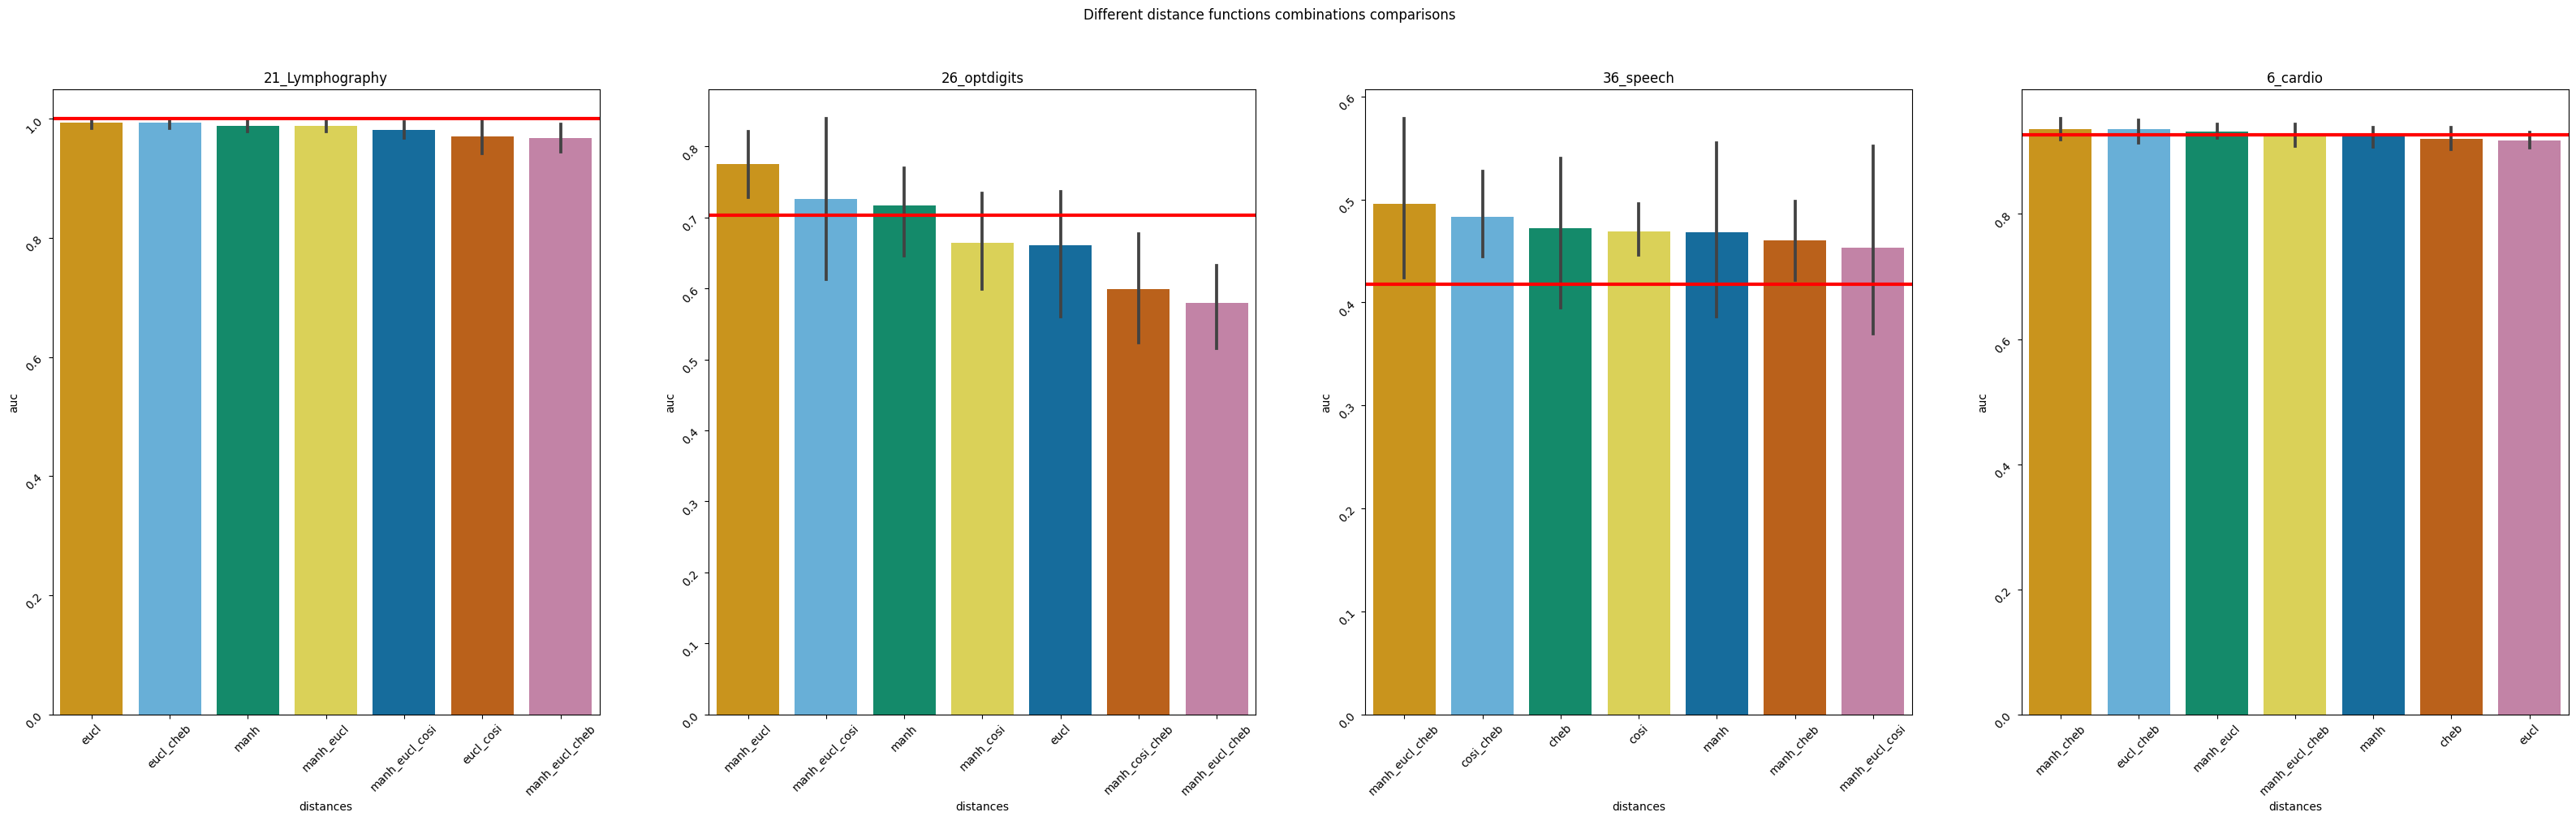

In [9]:
from pathlib import Path
SELECTED_PATH = Path("../results/selected_distances")
num_df = pd.read_csv(SELECTED_PATH / "results_selected_distances_numerical.csv")
plot_top_n_dists(num_df)

C:\Users\sebas\AppData\Local\Temp\ipykernel_12608\949431665.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_mean = grouped.mean().reset_index()


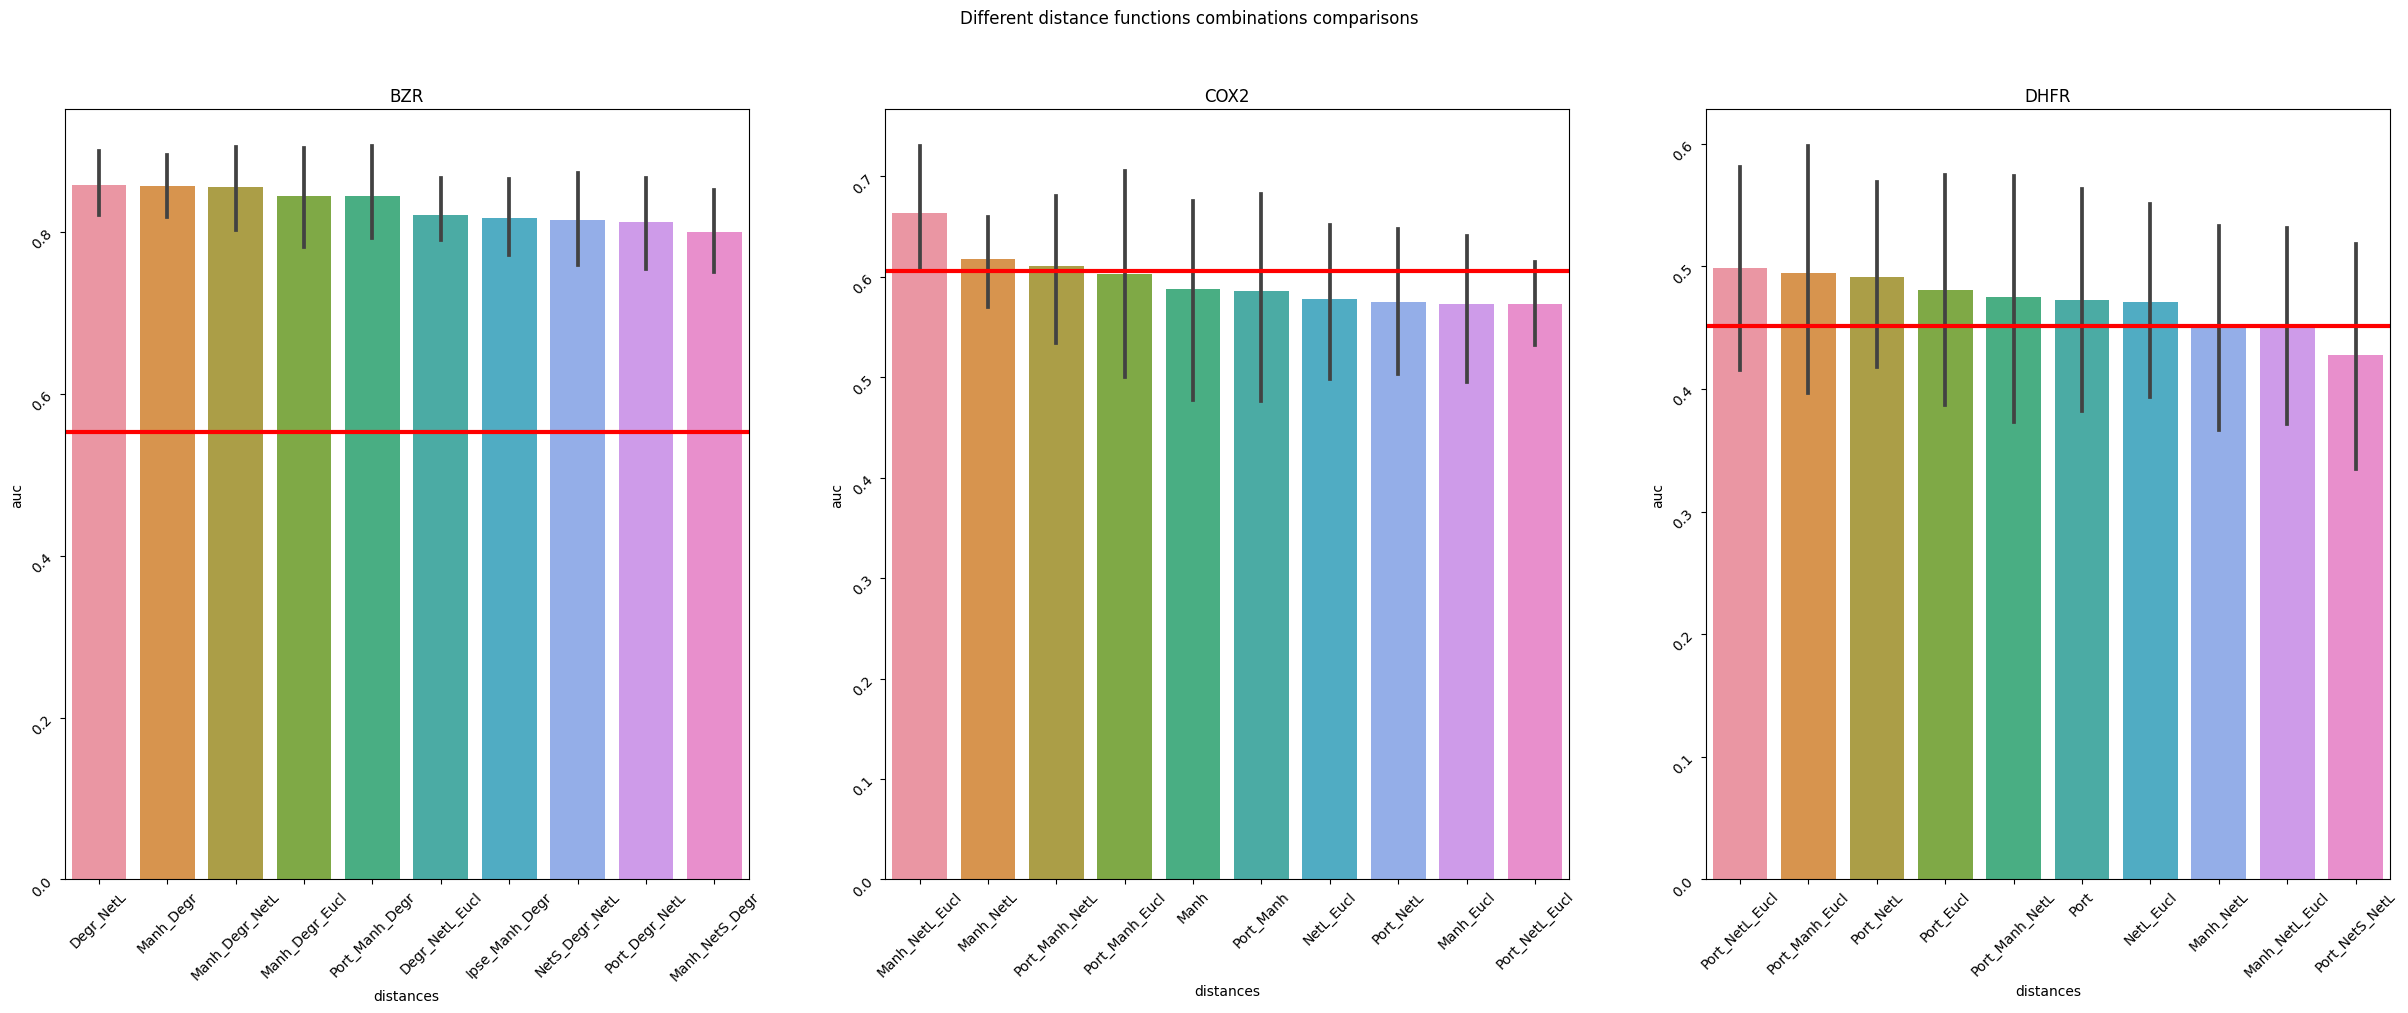

In [10]:
num_df = pd.read_csv(SELECTED_PATH / "results_selected_distances_graph.csv")
plot_top_n_dists(num_df, n = 10)

C:\Users\sebas\AppData\Local\Temp\ipykernel_12608\949431665.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_mean = grouped.mean().reset_index()


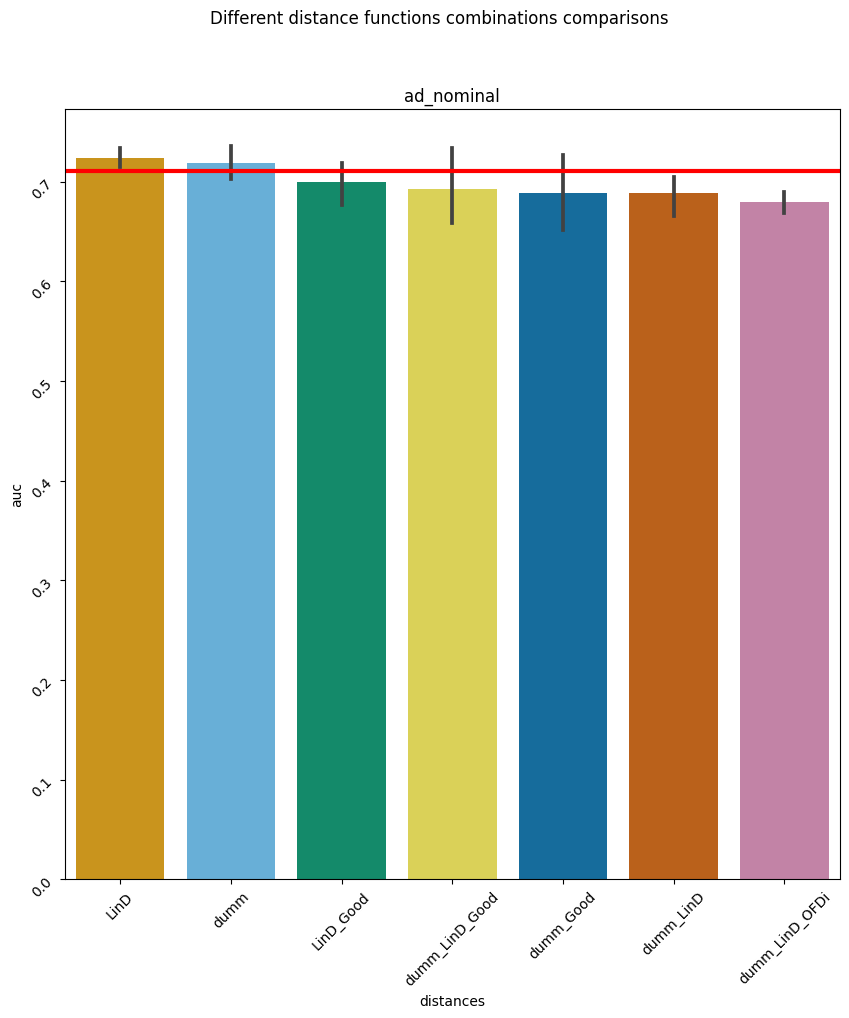

In [11]:
num_df = pd.read_csv(SELECTED_PATH / "results_selected_distances_binary.csv")
plot_top_n_dists(num_df)

C:\Users\sebas\AppData\Local\Temp\ipykernel_1608\949431665.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_mean = grouped.mean().reset_index()


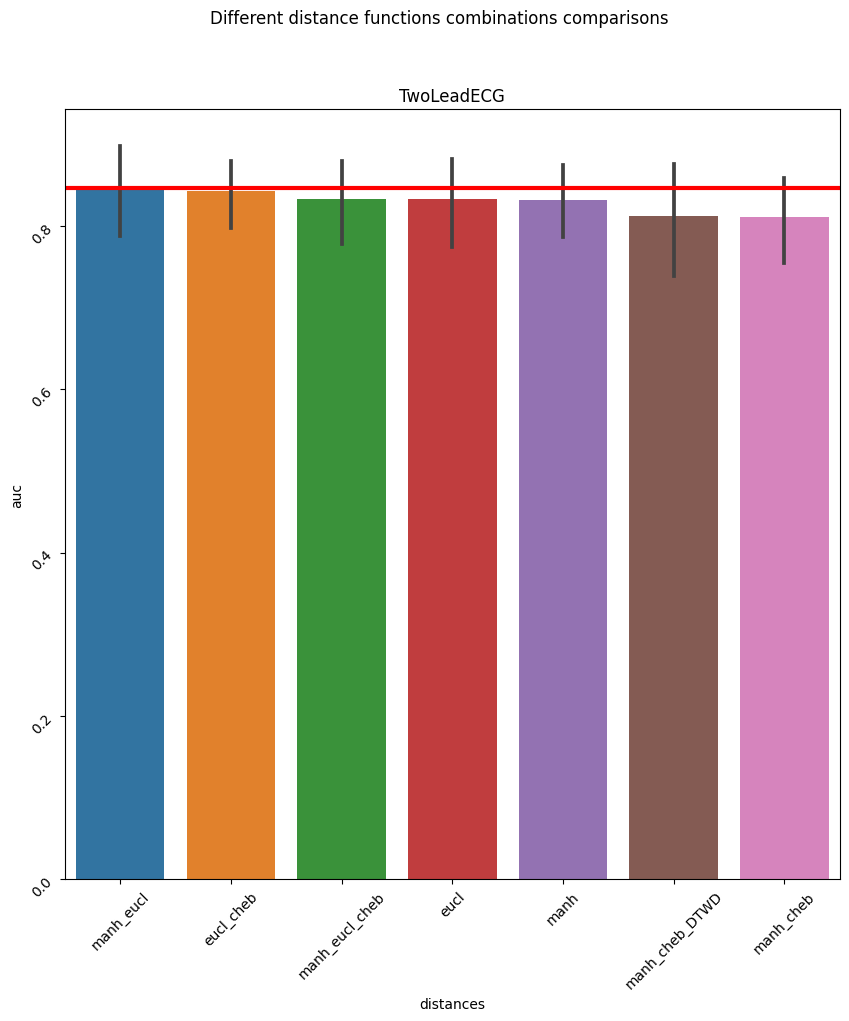

In [31]:
num_df = pd.read_csv(SELECTED_PATH / "results_selected_distances_timeseries.csv")
plot_top_n_dists(num_df)

C:\Users\sebas\AppData\Local\Temp\ipykernel_12608\949431665.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_mean = grouped.mean().reset_index()


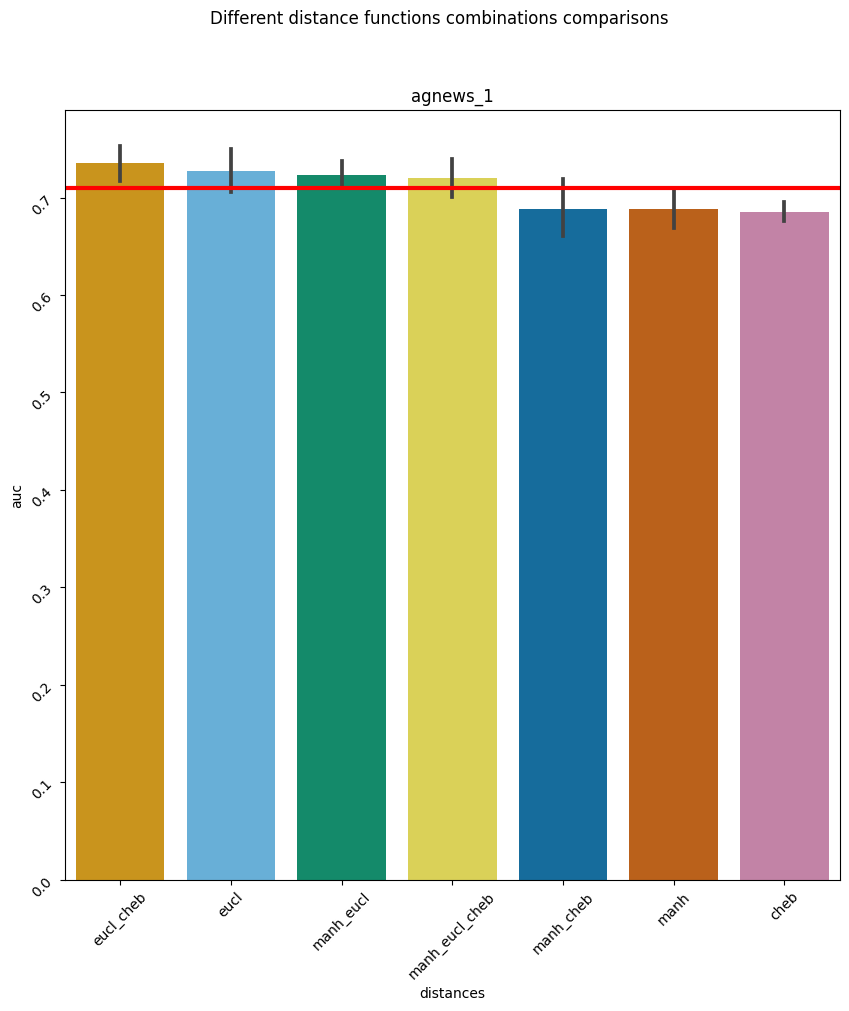

In [12]:
num_df = pd.read_csv(SELECTED_PATH / "results_selected_distances_nlp.csv")
plot_top_n_dists(num_df)

### Final outcomes

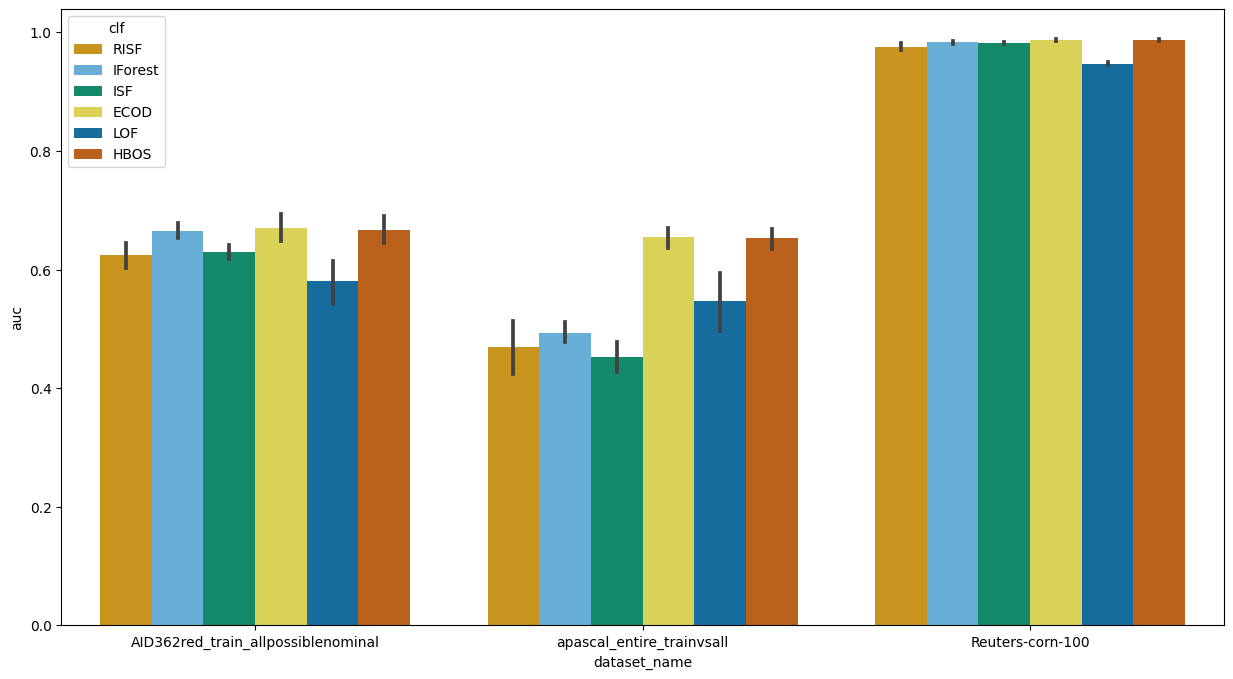

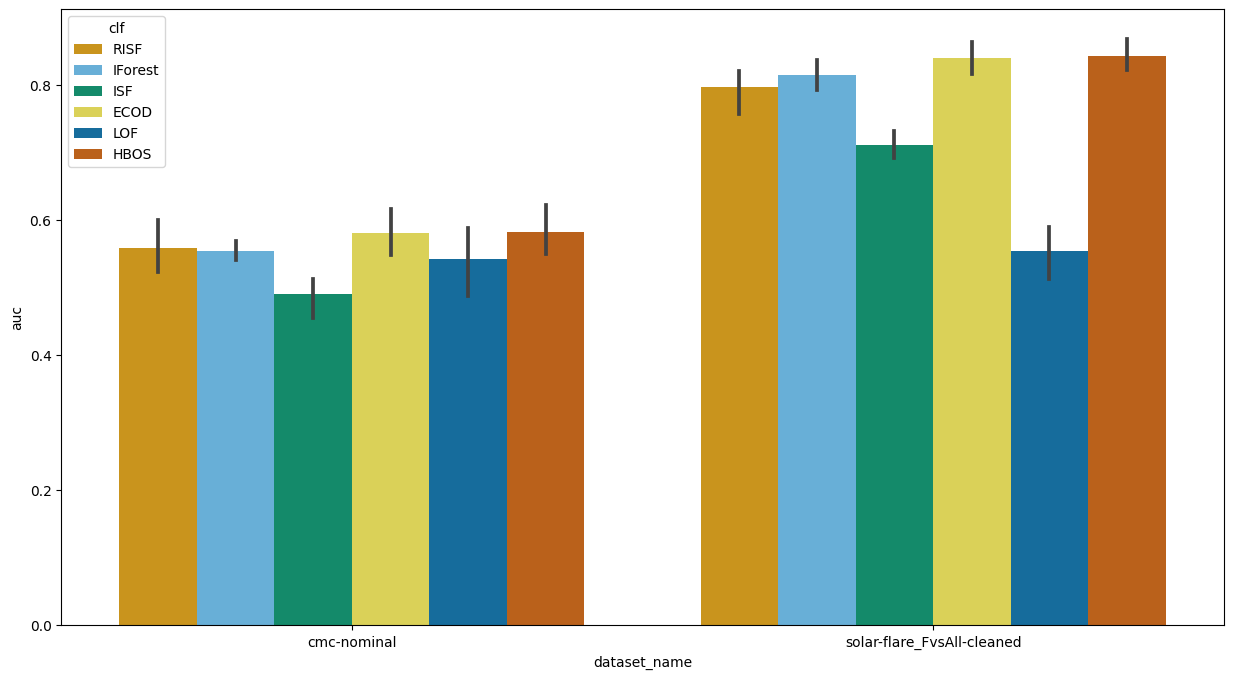

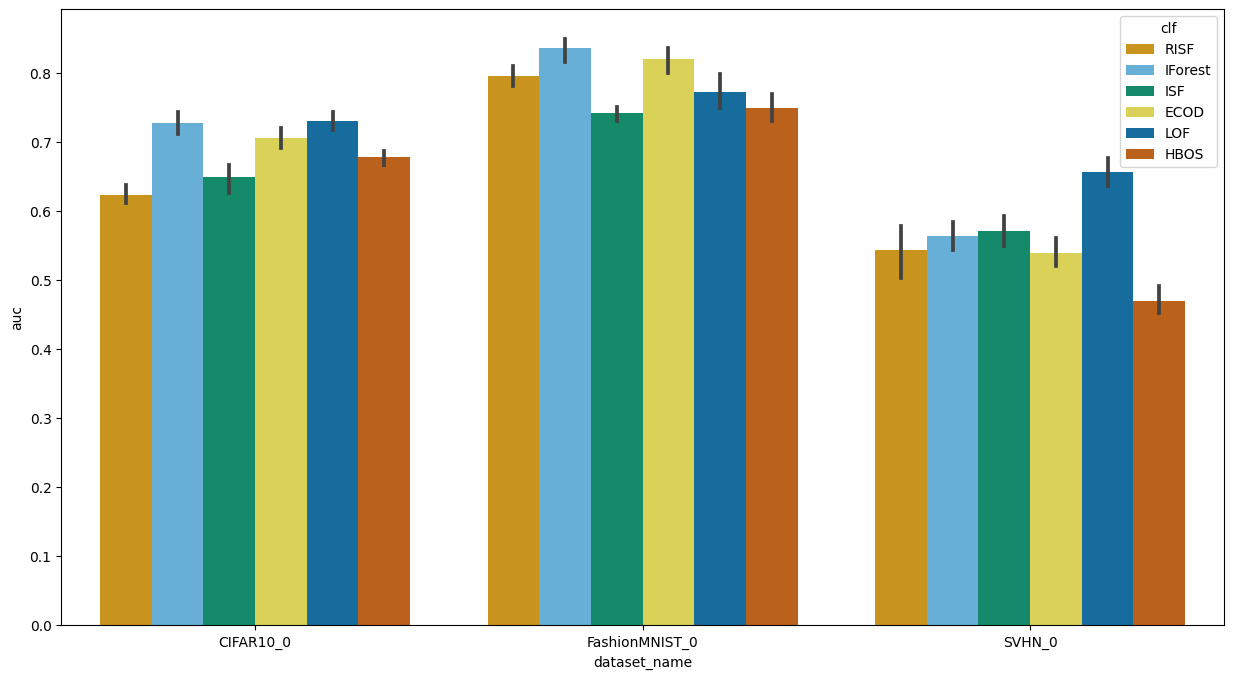

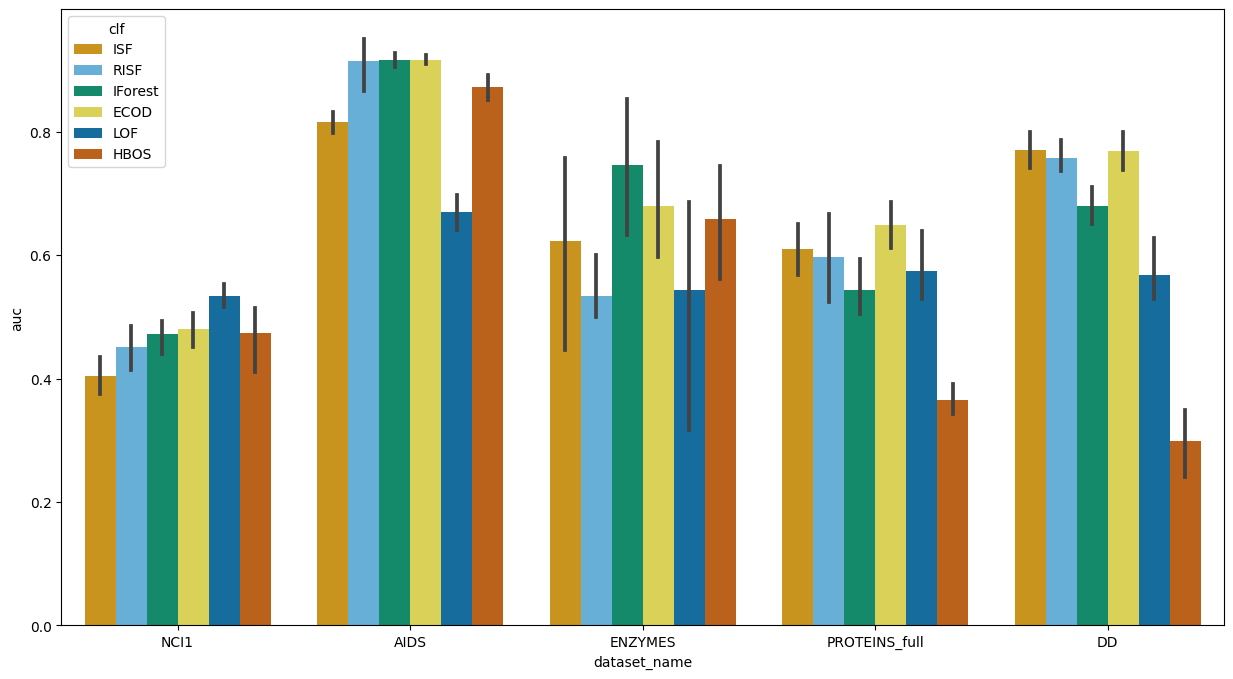

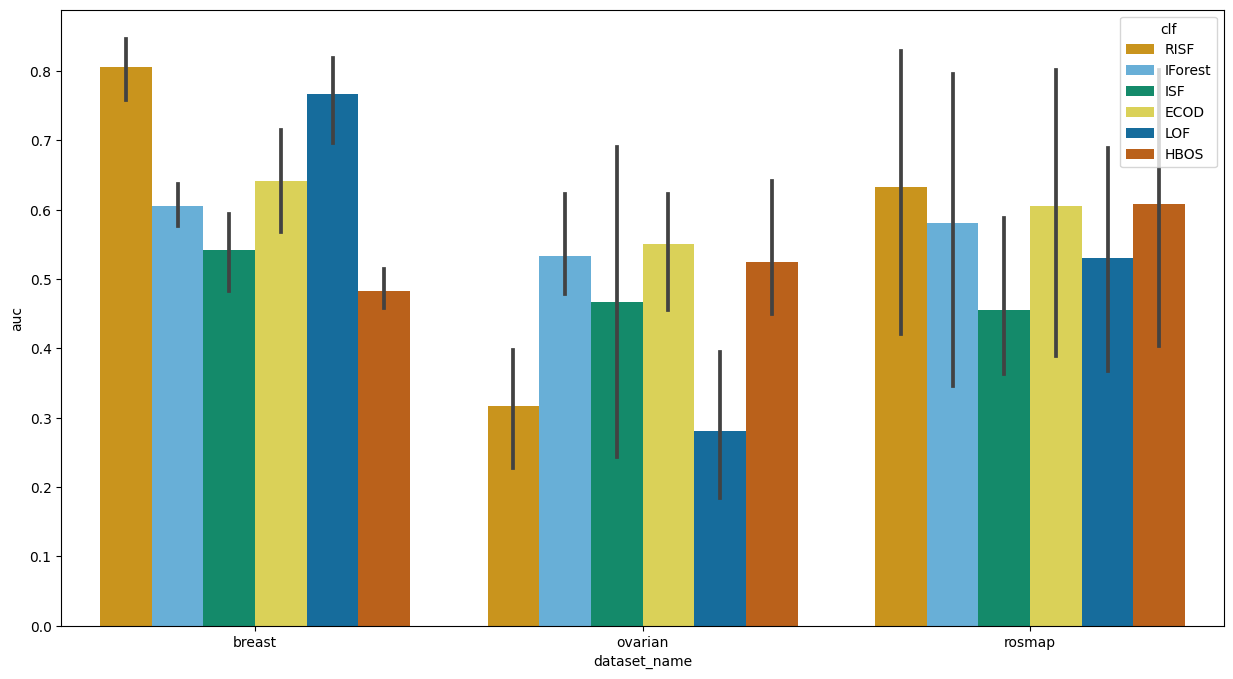

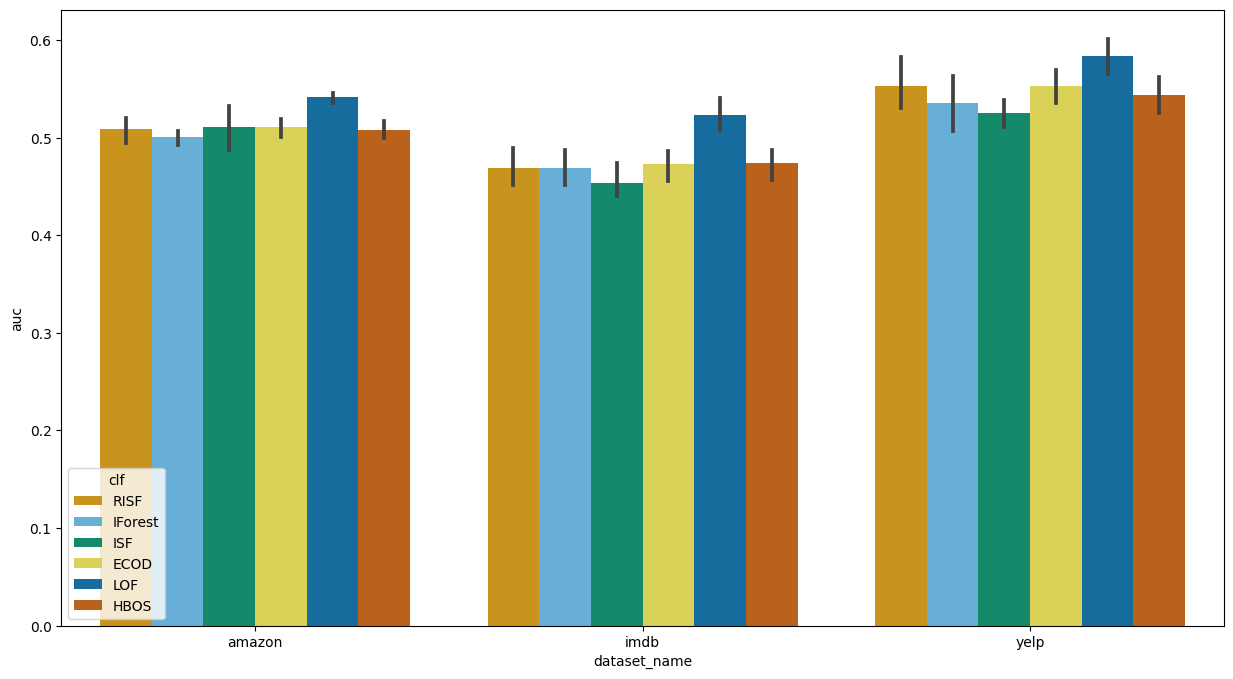

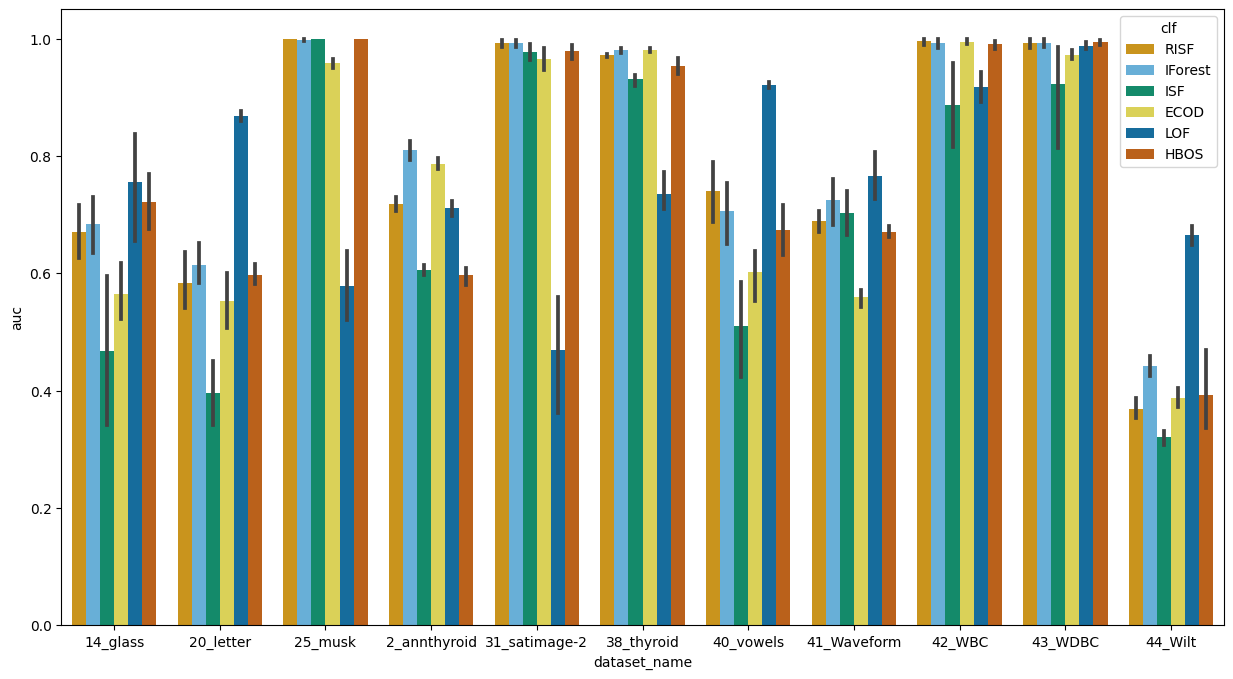

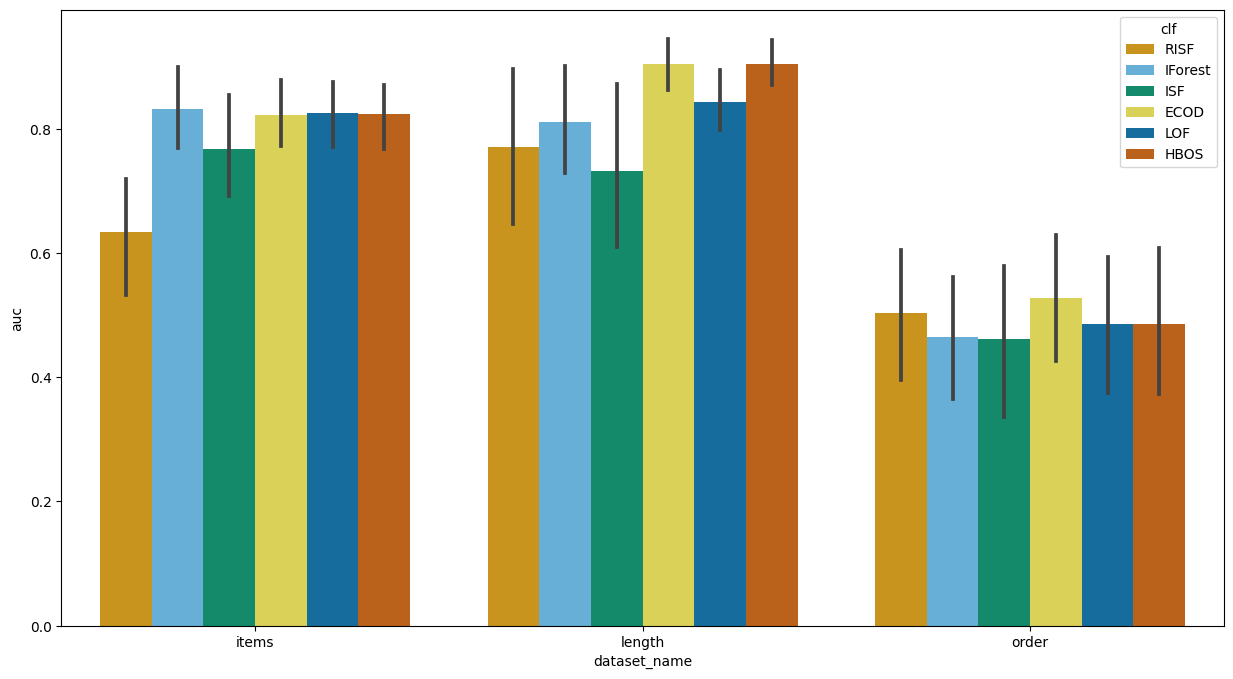

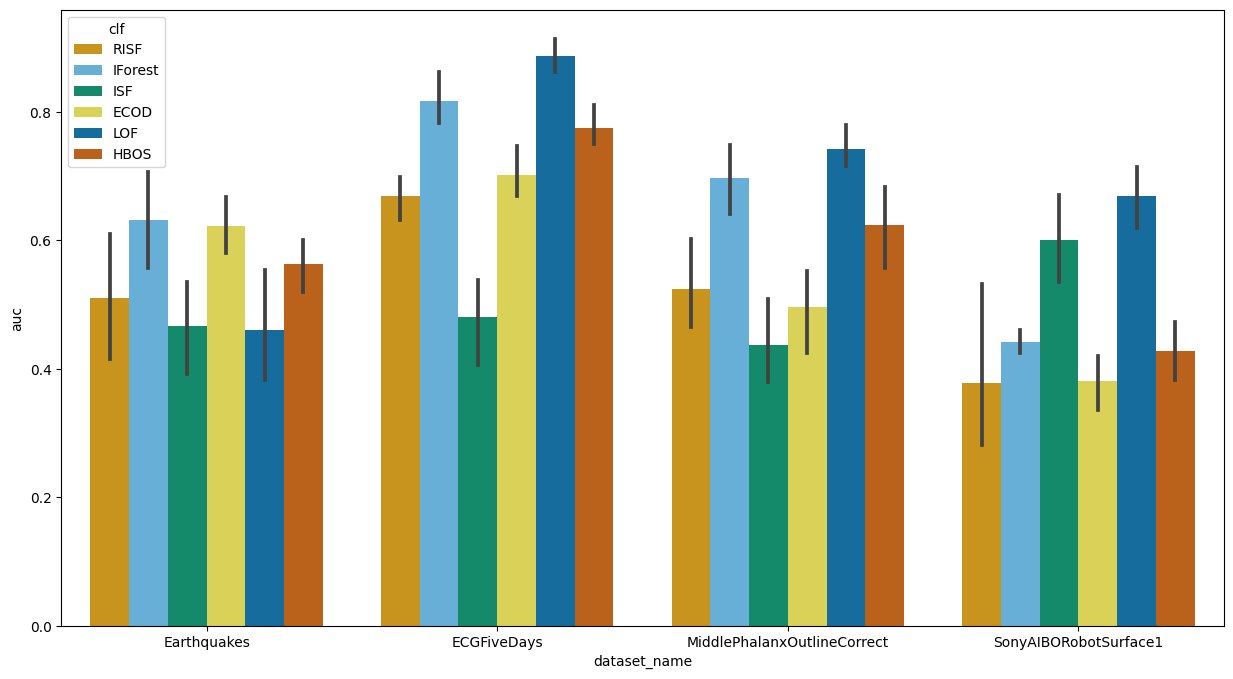

In [13]:
for dtype in ["binary", "nominal", "cv", "graph", "multiomics", "nlp", "numerical", "seq_of_sets", "timeseries"]:
    df = pd.read_csv(f'../results/experiments/{dtype}.csv')
    sns.barplot(data=df, x="dataset_name", y="auc", hue="clf")
    plt.gcf().set_size_inches(15, 8)
    plt.show()

# TODO:
* wybrac dystanse jakims rankiem.
* bierzemy bardzo proste rzeczy, nie wybieramy wiele roznych dystansow. Taki jest plus, ze dzialamy albo jak IF albo jak SF a w mixed dominujemy.
* `Robimy hyperparameter tuning.`
* `Dla sensitivity analysis dodac dummy i ma byc wtedy bardzo blisko IF.`
* `Zrobic tabelke i policzyc srednie ranki i zrobic testy statyczne.`

1. tabelka
2. dummy
3. hyperparameter search

### statistical tests


In [89]:
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp

In [102]:
dfs = []
for dtype in ["binary", "nominal", "cv", "graph", "multiomics", "nlp", "numerical", "seq_of_sets", "timeseries"]:
    dfs.append(pd.read_csv(f'../results/experiments/{dtype}.csv'))

df = pd.concat(dfs)
df = df.groupby(['dataset_name', 'clf']).mean(numeric_only=True).reset_index()
df_table = pd.pivot_table(df, values='auc', index=['dataset_name'], columns=['clf'])

Text(0.5, 1.0, 'std of AUC for each dataset and classifier')

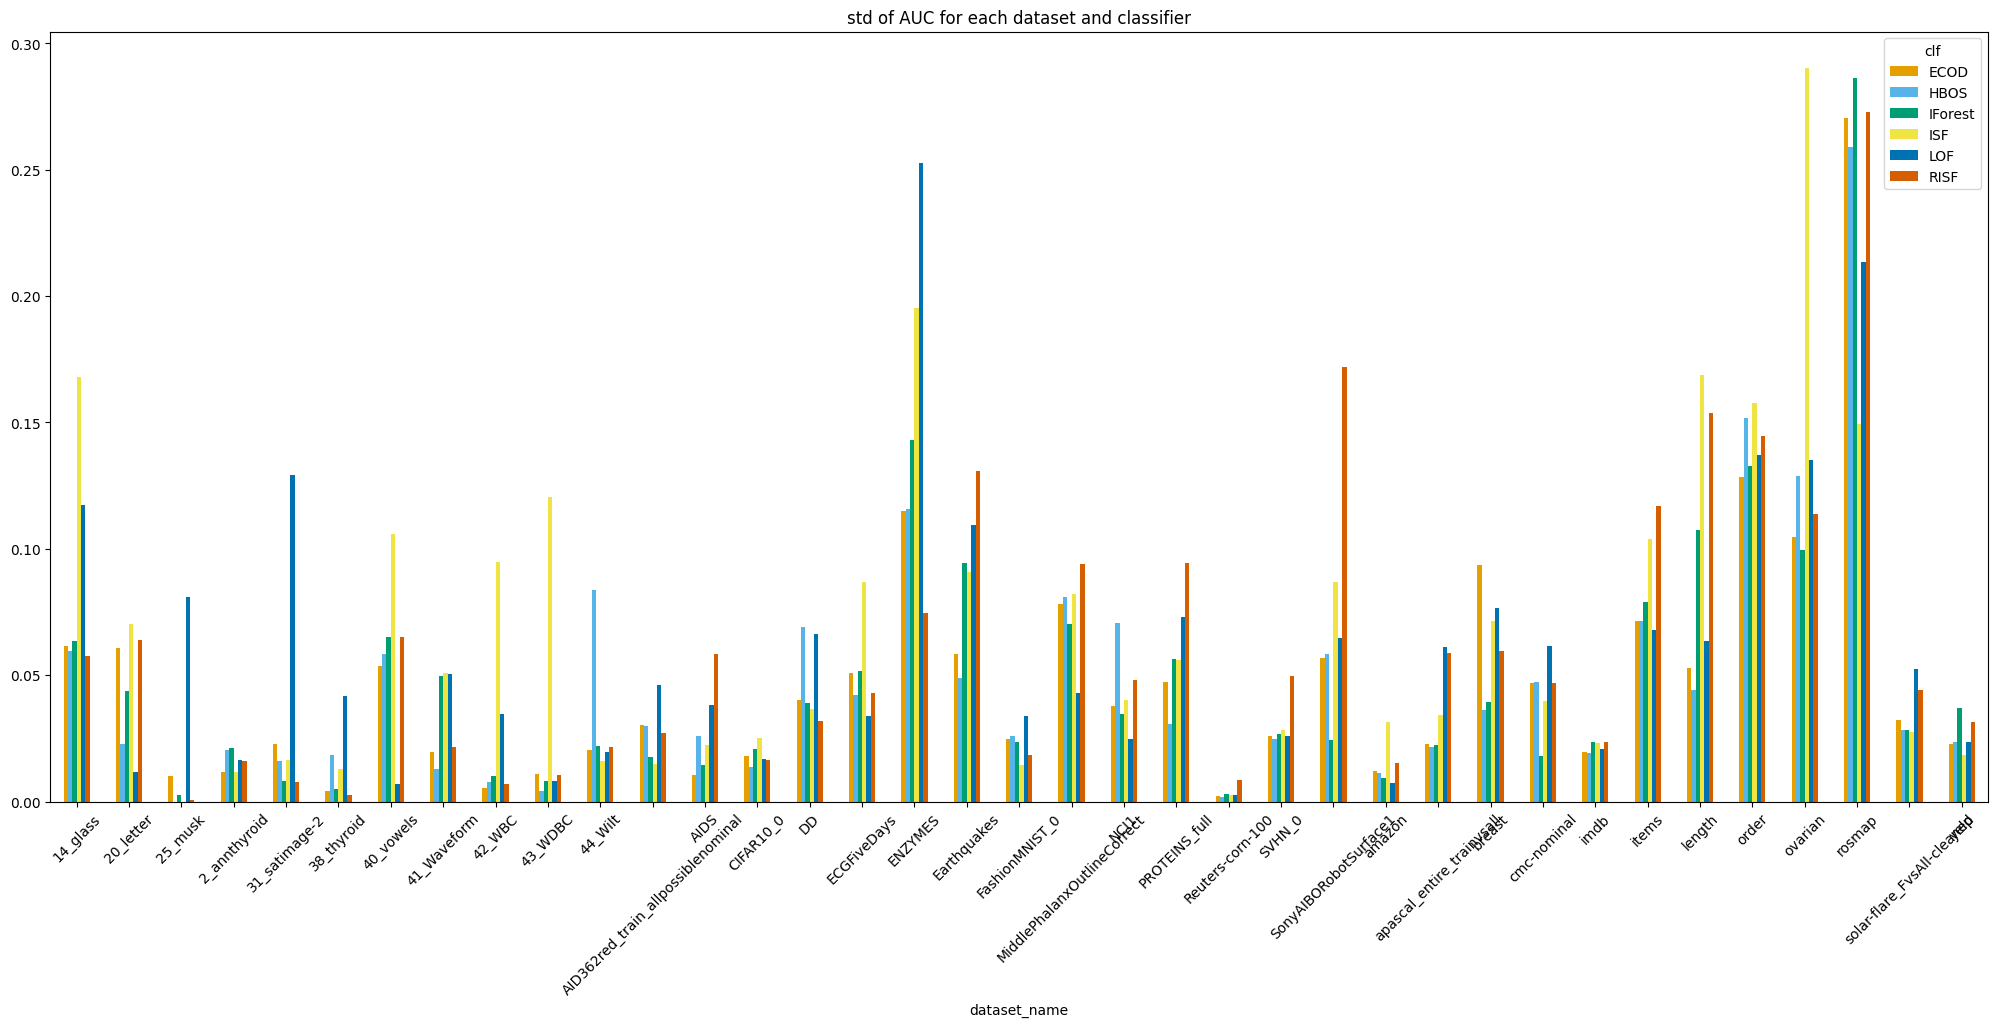

In [101]:
df_table.plot(kind='bar', figsize=(25, 10))
plt.xticks(rotation=45)
plt.title("std of AUC for each dataset and classifier")

In [60]:
friedmanchisquare(*[df_table[c] for c in df_table.columns])

FriedmanchisquareResult(statistic=25.587326120556455, pvalue=0.00010727600536007166)

In [61]:
posthoc = sp.posthoc_wilcoxon(df_table.T.to_numpy())
posthoc.columns = df_table.columns
posthoc.index = df_table.columns.values
posthoc

c:\Users\sebas\mambaforge\lib\site-packages\scipy\stats\_morestats.py:3255: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


clf,ECOD,HBOS,IForest,ISF,LOF,RISF
ECOD,1.000000,0.411105,0.419708,0.000022,0.520913,0.085522
HBOS,0.411105,1.000000,0.019720,0.004920,0.698206,0.385915
IForest,0.419708,0.019720,1.000000,0.000013,0.550494,0.012697
ISF,0.000022,0.004920,0.000013,1.000000,0.097367,0.005340
LOF,0.520913,0.698206,0.550494,0.097367,1.000000,0.601519
RISF,0.085522,0.385915,0.012697,0.005340,0.601519,1.000000


In [62]:
# mean rank
ranks = []
for row in df_table.iterrows():
    id_, row = row
    ranks.append(row.rank(ascending=False).values)

pd.Series(np.mean(ranks, axis=0), index=df_table.columns)

clf
ECOD       2.891892
HBOS       3.391892
IForest    2.891892
ISF        4.743243
LOF        3.297297
RISF       3.783784
dtype: float64

### Variance of results analysis.

At first let's see differences between 2 implementations of same algorithm for RISF we obtained IForest like behaviour by using dummy projection.

In [208]:
#Sanity Check if two implementations are the same.
df = pd.read_csv("../results/results_numerical_dummy_dist.csv").groupby(["clf", "dataset_name"]).auc.mean().reset_index().pivot(index="dataset_name", columns="clf", values="auc")
df['diff'] = df['IForest'] - df['RISF']
df

clf,IForest,RISF,diff
dataset_name,,,
14_glass,0.68390,0.69462,-0.01072
20_letter,0.61488,0.64108,-0.02620
21_Lymphography,1.00000,1.00000,0.00000
25_musk,0.99800,1.00000,-0.00200
26_optdigits,0.70296,0.65056,0.05240
2_annthyroid,0.81034,0.81518,-0.00484
31_satimage-2,0.99342,0.99540,-0.00198
36_speech,0.41798,0.40036,0.01762
38_thyroid,0.98074,0.98350,-0.00276


Now let's see plot with n_holdouts vs deviation/mean.

In [199]:
plt.rcParams["figure.figsize"] = (25,5)
df = pd.read_csv("../results/results_20holdouts_sensitivity_datasets.csv")
#Now just for I forest
df = df.set_index(["dataset_name", "clf"])
data_to_plot = []
for dataset_name, clf in np.unique(df.index.to_numpy()):
    results = df.loc[(dataset_name, clf)].reset_index()
    for n_holdouts in range(1, len(results)+1):
        samples = results.iloc[:n_holdouts, 3].to_numpy()
        data_to_plot.append({
            "dataset_name": dataset_name,
            "clf": clf,
            "n_holdouts": n_holdouts,
            "auc_std": samples.std(),
            "auc_mean": samples.mean(),
            "samples": samples
        })
df_plt = pd.DataFrame(data_to_plot)

C:\Users\sebas\AppData\Local\Temp\ipykernel_14536\3885823806.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  results = df.loc[(dataset_name, clf)].reset_index()
C:\Users\sebas\AppData\Local\Temp\ipykernel_14536\3885823806.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  results = df.loc[(dataset_name, clf)].reset_index()
C:\Users\sebas\AppData\Local\Temp\ipykernel_14536\3885823806.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  results = df.loc[(dataset_name, clf)].reset_index()
C:\Users\sebas\AppData\Local\Temp\ipykernel_14536\3885823806.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  results = df.loc[(dataset_name, clf)].reset_index()
C:\Users\sebas\AppData\Local\Temp\ipykernel_14536\3885823806.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  results = df.loc[(dataset_name, clf)].reset_index()
C:\Users\sebas\AppData\Local\Temp\i

In [200]:
df_plt[df_plt['dataset_name'] == "agnews_1"]

,dataset_name,clf,n_holdouts,auc_std,auc_mean,samples
1080,agnews_1,ECOD,1,0.000000,0.707700,[0.7077]
1081,agnews_1,ECOD,2,0.026100,0.733800,"[0.7077, 0.7599]"
1082,agnews_1,ECOD,3,0.021579,0.736200,"[0.7077, 0.7599, 0.741]"
1083,agnews_1,ECOD,4,0.021575,0.742425,"[0.7077, 0.7599, 0.741, 0.7611]"
1084,agnews_1,ECOD,5,0.021340,0.746980,"[0.7077, 0.7599, 0.741, 0.7611, 0.7652]"
...,...,...,...,...,...,...
1195,agnews_1,RISF,16,0.025075,0.722956,"[0.6845, 0.7044, 0.7254, 0.7522, 0.7319, 0.755..."
1196,agnews_1,RISF,17,0.025763,0.720835,"[0.6845, 0.7044, 0.7254, 0.7522, 0.7319, 0.755..."
1197,agnews_1,RISF,18,0.025101,0.721267,"[0.6845, 0.7044, 0.7254, 0.7522, 0.7319, 0.755..."
1198,agnews_1,RISF,19,0.024871,0.720168,"[0.6845, 0.7044, 0.7254, 0.7522, 0.7319, 0.755..."


In [201]:
# import seaborn as sns
# sns.barplot(data=df_plt, x="n_holdouts", y="auc_std", hue="dataset_name", palette="tab10")
# plt.title("AUC std for each dataset and number of holdouts for IForest")

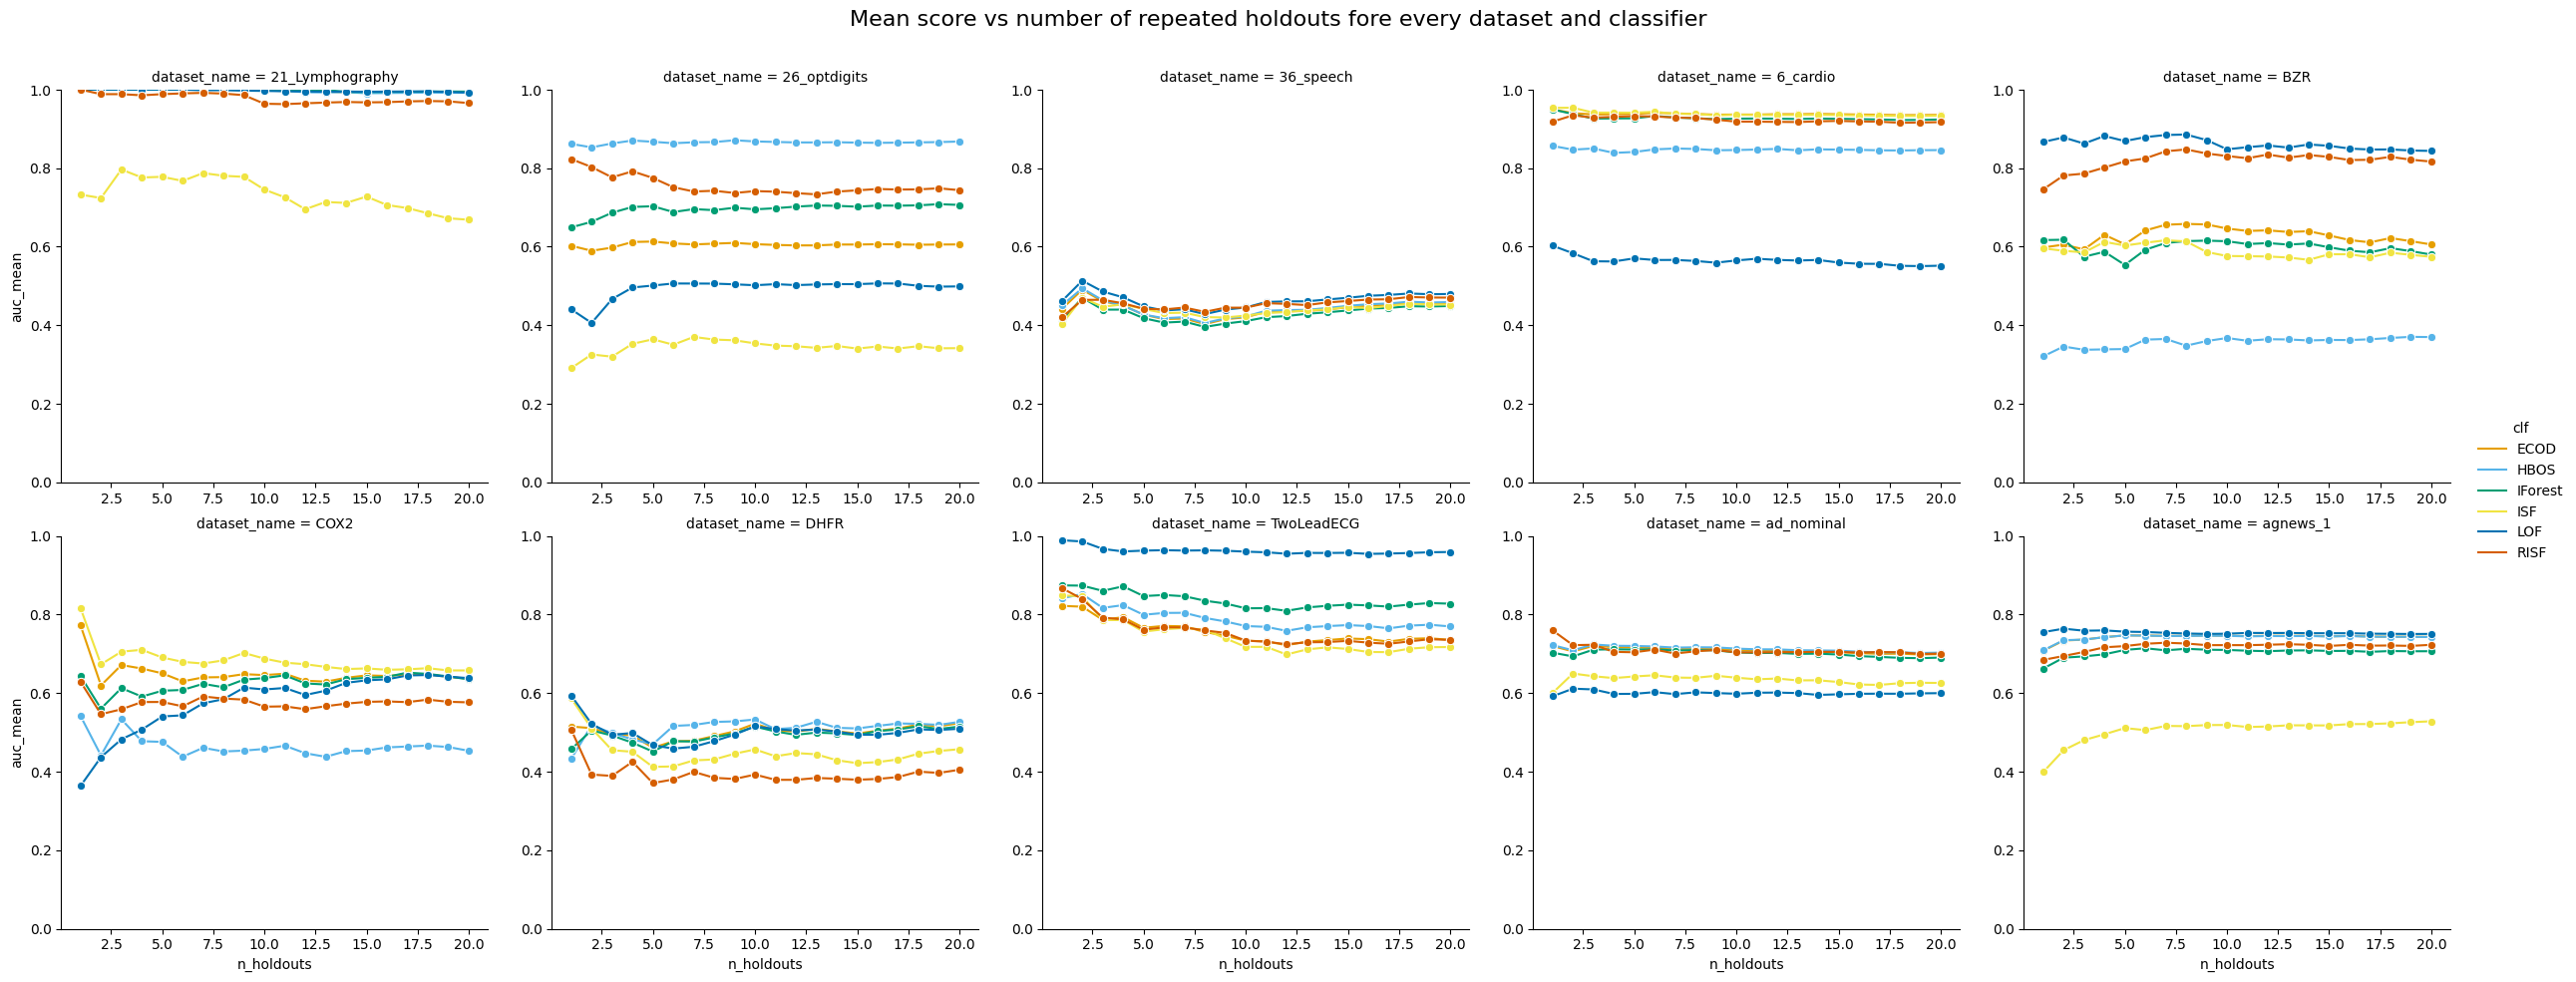

In [205]:
g = sns.relplot(data=df_plt,  x="n_holdouts", y="auc_mean", hue="clf", marker="o", col="dataset_name", col_wrap=5, 
                facet_kws={'sharey': False, 'sharex': False}, kind="line")
g.set(ylim=(0, 1))
g.fig.suptitle('Mean score vs number of repeated holdouts fore every dataset and classifier', fontsize=16)
g.fig.subplots_adjust(top=0.9)

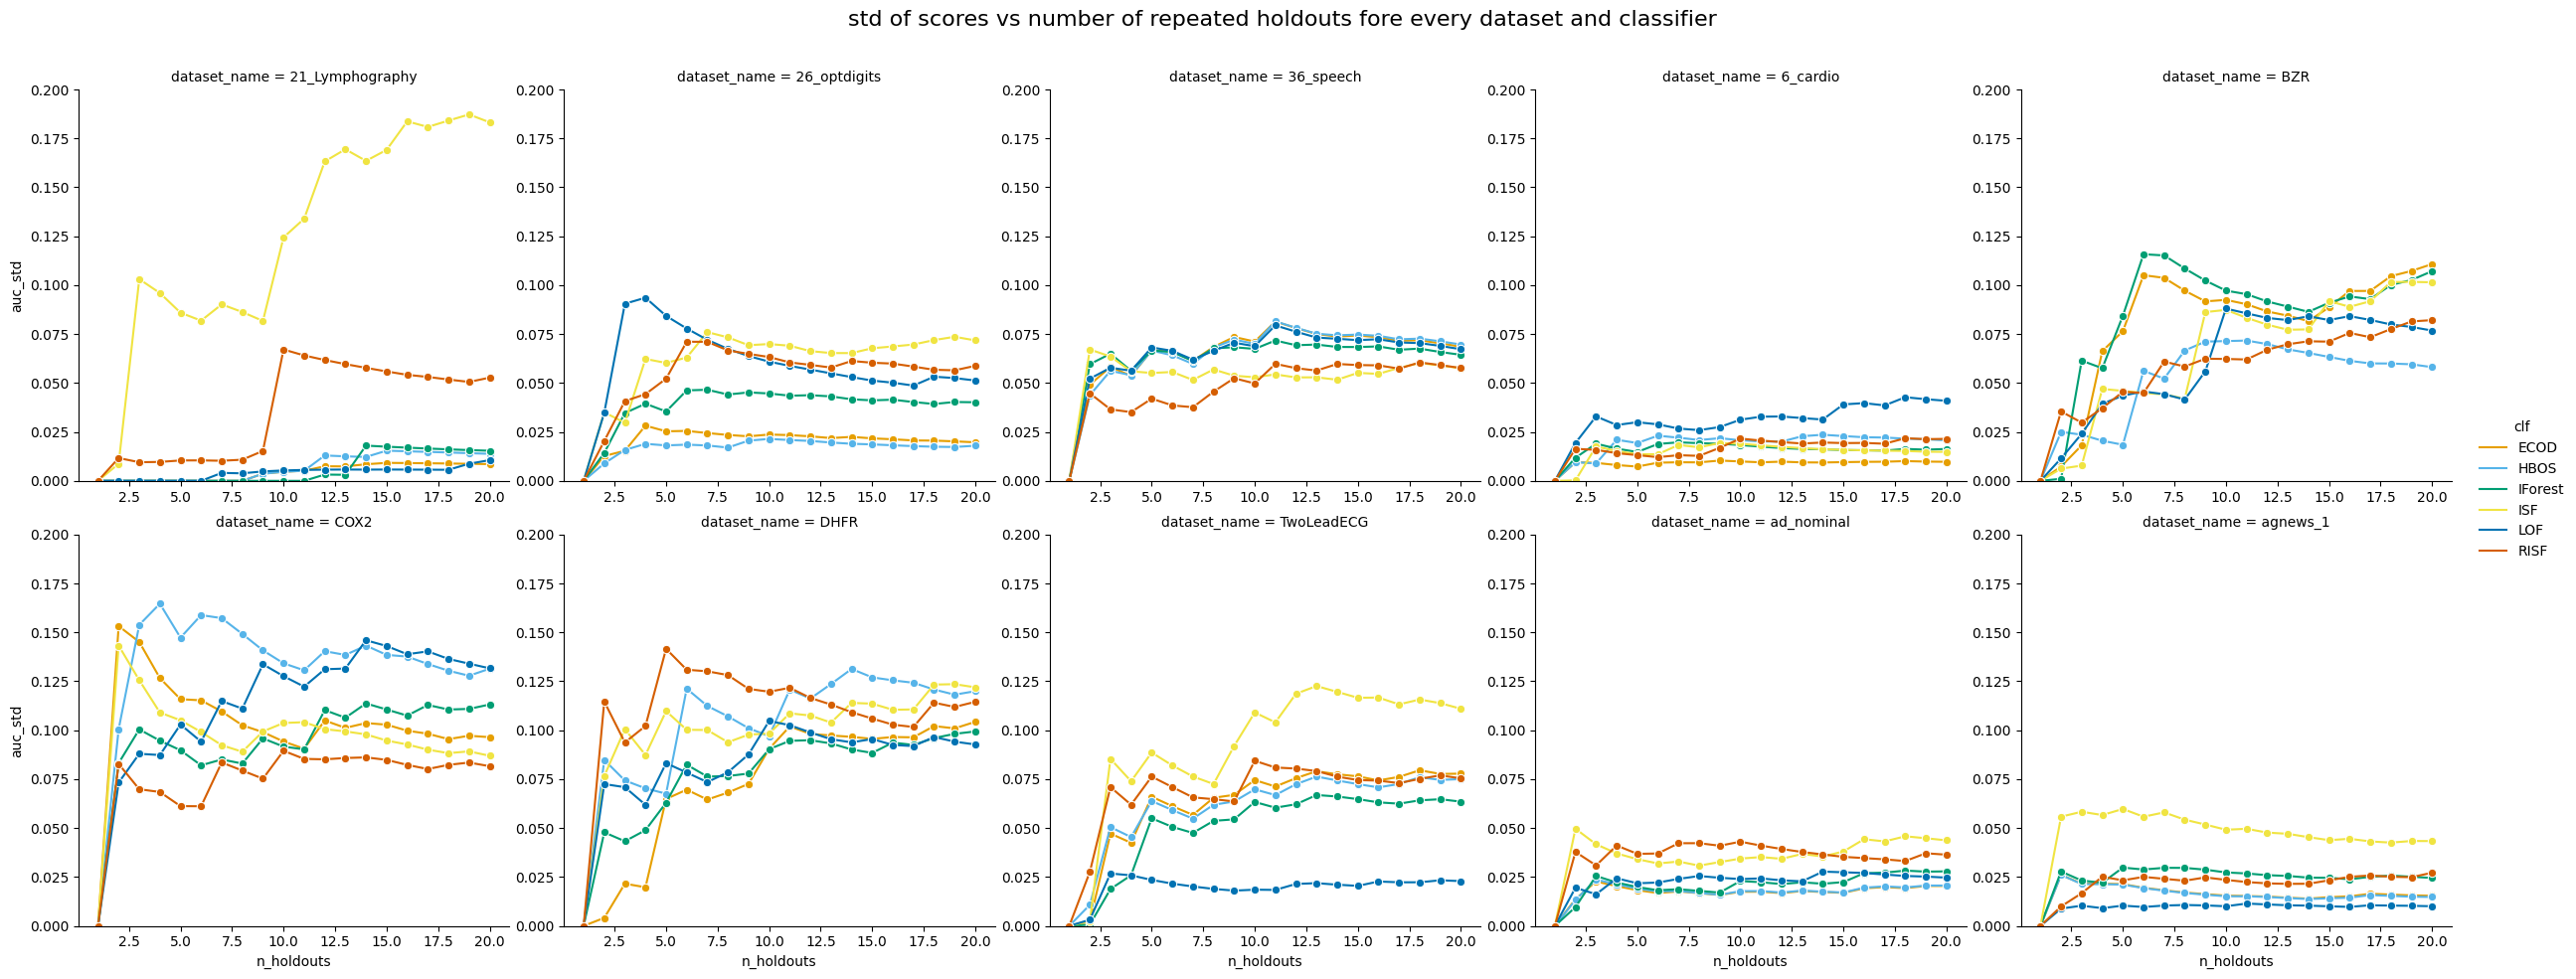

In [207]:
g = sns.relplot(data=df_plt,  x="n_holdouts", y="auc_std", hue="clf", marker="o", col="dataset_name", col_wrap=5, 
                facet_kws={'sharey': False, 'sharex': False}, kind="line")
g.set(ylim=(0, 0.2))
g.fig.suptitle('std of scores vs number of repeated holdouts fore every dataset and classifier', fontsize=16)
g.fig.subplots_adjust(top=0.9)